# Week 2: Measuring the (sub)halo mass function at any redshift

### Imports

In [1]:
import os
import numpy as np
import pickle
from helpers.SimulationAnalysis import SimulationAnalysis, readHlist
import matplotlib.pylab as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config InlineBackend.rc = {'figure.facecolor': 'w'}
# plt.rc("text", usetex=True)
custom_blues_complement = ["#FFBB99", "#FF9966", "#FF7733", "#FF5500", "#CC4400", "#993300", "#662200","#000000"]

sim_colors = {}
sim_colors['cdm'] = 'k'
sim_colors['wdm_3'] = custom_blues_complement[0]
sim_colors['wdm_4'] = custom_blues_complement[1]
sim_colors['wdm_5'] = custom_blues_complement[2]
sim_colors['wdm_6'] = custom_blues_complement[3]
sim_colors['wdm_6.5'] = custom_blues_complement[4]
sim_colors['wdm_10'] = custom_blues_complement[5]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Load Data

### Load compressed data

This is what we used in the Week 1 notebook.

In [55]:
# with open("/central/groups/carnegie_poc/enadler/ncdm_resims/analysis/sim_data.bin", "rb") as f:
#     sim_data = pickle.load(f, encoding='latin1')

In [2]:
with open("sim_data.bin", "rb") as f:
    sim_data = pickle.load(f, encoding='latin1')

### Load `hlists` directly

To measure how (sub)halo mass functions evolve, we'll need to load the halo lists (`hlists`) directly at different output snapshots. First, let's define the path to the simulation data and see what's available for a specific realization and model.

Here are all of the `hlists` that exist for the `Halo004` + `cdm` simulation. Each `hlist` is labeled by its scale factor $a$, which is related to redshift $z$ via $a=1/(1+z)$.

In [3]:
BASE_PATH = '' #'/central/groups/carnegie_poc/enadler/ncdm_resims/'

halo_num = 'Halo004/'
model = 'cdm/'

print(os.listdir(BASE_PATH+f'hlists_{model}'))
# print(os.listdir(BASE_PATH+halo_num+model+'output/rockstar/hlists/'))

['hlist_0.91463.list', 'hlist_0.45368.list', 'hlist_0.05608.list', 'hlist_0.30950.list', 'hlist_0.05537.list', 'hlist_0.14776.list', 'hlist_0.19810.list', 'hlist_0.93825.list', 'hlist_0.05262.list', 'hlist_0.13174.list', 'hlist_0.09579.list', 'hlist_0.19312.list', 'hlist_0.09220.list', 'hlist_0.84728.list', 'hlist_0.19559.list', 'hlist_0.11597.list', 'hlist_0.14404.list', 'hlist_0.13007.list', 'hlist_0.42566.list', 'hlist_0.05901.list', 'hlist_0.10607.list', 'hlist_0.09826.list', 'hlist_0.13343.list', 'hlist_0.07615.list', 'hlist_0.89161.list', 'hlist_0.35158.list', 'hlist_0.08220.list', 'hlist_0.11451.list', 'hlist_0.51536.list', 'hlist_0.17439.list', 'hlist_0.06290.list', 'hlist_0.16785.list', 'hlist_0.20064.list', 'hlist_0.12050.list', 'hlist_0.22219.list', 'hlist_0.82595.list', 'hlist_0.21659.list', 'hlist_0.50239.list', 'hlist_0.34713.list', 'hlist_0.07423.list', 'hlist_0.09702.list', 'hlist_0.05977.list', 'hlist_0.29789.list', 'hlist_0.06619.list', 'hlist_0.24292.list', 'hlist_0.

### Re-format

Since this is unwieldy, let's find the scale factor of each `hlist` and store the `hlists` in a dictionary:

*Note: when changing the model, we can't assume that the exact same set of scale factors will be present. Scale factors may change slightly between simulations; in addition, non-CDM models may not have `hlists` until a sufficiently large $a$ because halo formation is delayed.*

In [4]:
hlist_dictionary = {
    float(hlist[6:-5]): hlist
    for hlist in np.sort(os.listdir(BASE_PATH + f'hlists_{model}'))
    # for hlist in np.sort(os.listdir(BASE_PATH + halo_num + model + 'output/rockstar/hlists/'))
}

print(hlist_dictionary)

{0.05: 'hlist_0.05000.list', 0.05064: 'hlist_0.05064.list', 0.05129: 'hlist_0.05129.list', 0.05195: 'hlist_0.05195.list', 0.05262: 'hlist_0.05262.list', 0.05329: 'hlist_0.05329.list', 0.05397: 'hlist_0.05397.list', 0.05467: 'hlist_0.05467.list', 0.05537: 'hlist_0.05537.list', 0.05608: 'hlist_0.05608.list', 0.0568: 'hlist_0.05680.list', 0.05753: 'hlist_0.05753.list', 0.05827: 'hlist_0.05827.list', 0.05901: 'hlist_0.05901.list', 0.05977: 'hlist_0.05977.list', 0.06054: 'hlist_0.06054.list', 0.06131: 'hlist_0.06131.list', 0.0621: 'hlist_0.06210.list', 0.0629: 'hlist_0.06290.list', 0.0637: 'hlist_0.06370.list', 0.06452: 'hlist_0.06452.list', 0.06535: 'hlist_0.06535.list', 0.06619: 'hlist_0.06619.list', 0.06704: 'hlist_0.06704.list', 0.0679: 'hlist_0.06790.list', 0.06877: 'hlist_0.06877.list', 0.06965: 'hlist_0.06965.list', 0.07054: 'hlist_0.07054.list', 0.07145: 'hlist_0.07145.list', 0.07236: 'hlist_0.07236.list', 0.07329: 'hlist_0.07329.list', 0.07423: 'hlist_0.07423.list', 0.07519: 'hlist

### Load test `hlist`

Now that we have the paths to these `hlists`, let's load one of them to see what it contains. Here, I chose $a=0.93825$, but this test can be repeated for any scale factor in the dictionary above.

In [5]:
test_hlist = readHlist(BASE_PATH + f'hlists_{model}' + hlist_dictionary[0.93825])

In [6]:
print(len(test_hlist))
print('\n')

print(test_hlist[0:2])
print('\n')

print(test_hlist.dtype)
print('\n')

25377


[(0.93825, 7060540, 0.95029, 7090425, 22,      -1,      -1, -1, 0, 6.125e+11, 6.188e+11, 179.7  , 17.653, 154.03, 1, 0.37953, 149.7 , 64.68105, 62.76966, 64.75536, 128.74,  48.48, 127.06, 5.424e+11,  2.295e+11,  3.788e+11, 0.03718, 252,      5, 7208101, 14103, 230., 301592, 301591,    235, 0.     ,      -1, 18.9217 , 6.1892e+11, 7.0323e+11, 4.8301e+11, 3.9670e+11, 2.0889e+11, 14.7868 , 28.73, 0.03777, 0.74388, 0.49734, -1.77936, 5.02744, 2.74194, 0.68331, 0.45818, -1.66901, 4.54419, 1.45544, 0.6025, 6.724e+11, 3.333e+11, 64.232, 54.7472 , 6.188e+11, 6.188e+11, 149.7 , 161.08, 0.39938, 355.7, 355.7,  8.340e+01,  4.967e+01, 47.4, -1.644e-11,  7.279e-12, 0.93825, 0.93825, 0.93825, 6.188e+11, 149.7 , 149.7, 0.     ,  0.01364, -1.     , 7060540)
 (0.93825, 7060542, 0.95029, 7090425,  1, 7060540, 7060540, -1, 0, 7.896e+06, 7.896e+06,   4.199,  0.194,   5.62, 0, 0.13343,   4.32, 64.65173, 62.76049, 64.70574,  88.8 , 112.41, 105.39, 5.979e+03, -8.553e+03, -2.471e+03, 0.0624 , 253, 3015

Note that, unlike the compressed data, we haven't yet split the `hlist` into isolated halos vs. subhalos of the main host. We can see this through the `upid` values, which list the `id` of the largest halo that each object in the `hlist` lives within. If a halo is isolated, its `upid` equals $-1$; otherwise, it's a subhalo.

Here's a look at the first few unique `upid` values in the `test_hlist` we loaded. Below, we'll see how to identify which of these `upid`s corresponds to the main host.

In [7]:
print(np.unique(test_hlist['upid'])[0:5])

[     -1 7050008 7050019 7050023 7050031]


## Recreate compressed data at $z=0$

The $a=1$ `hlist` was used to generate the compressed data from Week 1, so let's first recreate the compressed data.

First, let's define a function that returns the isolated halos and subhalos at any redshift:

In [8]:
# def load_sim_data(a,hlist_dictionary,host_mb,path):
#     halos = readHlist(path+'output/rockstar/hlists/{}'.format(hlist_dictionary[a]))
#     ###
#     isolated_halos = halos[halos['upid']==-1]
#     ###
#     host_ind = np.argmin(np.abs(host_mb['scale']-a))
#     subhalos = halos[halos['upid']==host_mb[host_ind]['id']]
#     ###
#     return isolated_halos, halos

In [16]:
def load_sim_data(a,hlist_dictionary,host_mb, model, path=''):
    halos = readHlist(path+f'hlists_{model}/{hlist_dictionary[a]}')
    ###
    isolated_halos = halos[halos['upid']==-1]
    ###
    host_ind = np.argmin(np.abs(host_mb['scale']-a))
    subhalos = halos[halos['upid']==host_mb[host_ind]['id']]
    ###
    return isolated_halos, subhalos

In [17]:
# halos, subhalos = load_sim_data(1.00000,hlist_dictionary,sim_data[halo_num[:-1]][model[:-1]][0],
#                                          BASE_PATH+halo_num+model)

halos, subhalos = load_sim_data(1.00000,hlist_dictionary,sim_data[halo_num[:-1]][model[:-1]][0],
                                         'cdm')

print(halos[0]==sim_data[halo_num[:-1]][model[:-1]][1][0])
print(subhalos[0]==sim_data[halo_num[:-1]][model[:-1]][2][0])

print()

[(1., 7208101, 0., -1, 29,      -1,      -1, -1, 0, 7.22500e+11, 7.225e+11, 184.336, 17.119, 173.14, 1, 0.37953, 163.98, 64.76799, 62.80204, 64.83894, 135.9 ,  61.16, 128.21,  4.125e+11,  2.752e+10, 7.358e+11, 0.03323,       0,       0, 7208101, 27169, 235., -1,  322075,     235, 0.     ,      -1, 15.0659 , 7.2402e+11, 7.6975e+11, 6.3331e+11, 5.2038e+11, 2.7904e+11, 9.9622 , 50.81, 0.03451, 0.60996, 0.49941, -1.2902 , 5.32596, 4.03564, 0.56355, 0.43875, -0.66184, 4.69694, 3.30171, 0.6536, 9.321e+11, 4.159e+11, 57.808, 56.9445 , 7.225e+11, 7.225e+11, 163.98, 163.98, 0.44226,  73.75  ,  73.75  ,  1.153e+02,  6.968e+01, 6.039e+01,  1.741e-10,  2.883e-11, 1.     , 1.     , 1.     , 7.225e+11, 163.98, 163.98, 0.     ,  0.05718, -1., 7208101)
 (1., 7208901, 0., -1,  4, 7208101, 7208101, -1, 0, 1.05600e+11, 1.056e+11,  97.108,  7.951,  96.86, 1, 0.64828,  84.22, 64.77139, 62.8354 , 64.86526,  55.39, -98.75, -83.4 ,  3.390e+10,  1.121e+10, 7.420e+10, 0.07096,  322076,  322076, 7208901, 10181, 

## Halo and subhalo populations at $z=0.5$

Now, let's repeat the exercises from the Week 1 notebook at $z=0.5$ (or $a=2/3$, roughly 5 billion years ago; e.g., see [here](https://www.astro.ucla.edu/~wright/CosmoCalc.html)), and let's compare them to the $z=0$ results.

In [65]:
scale_factors = np.array(list(hlist_dictionary.keys())) # list of scale factors
scale = scale_factors[np.argmin(np.abs(scale_factors-0.67))] # finding the closest value to z = 0.5 (using a = 0.67)
print(scale)

0.67356


In [66]:
halos_z_0_1, subhalos_z_0_1 = load_sim_data(scale,hlist_dictionary,sim_data[halo_num[:-1]][model[:-1]][0],'cdm')

In [67]:
host_main_branch = sim_data[halo_num[:-1]][model[:-1]][0]
host_ind = np.argmin(np.abs(host_main_branch['scale']-scale))

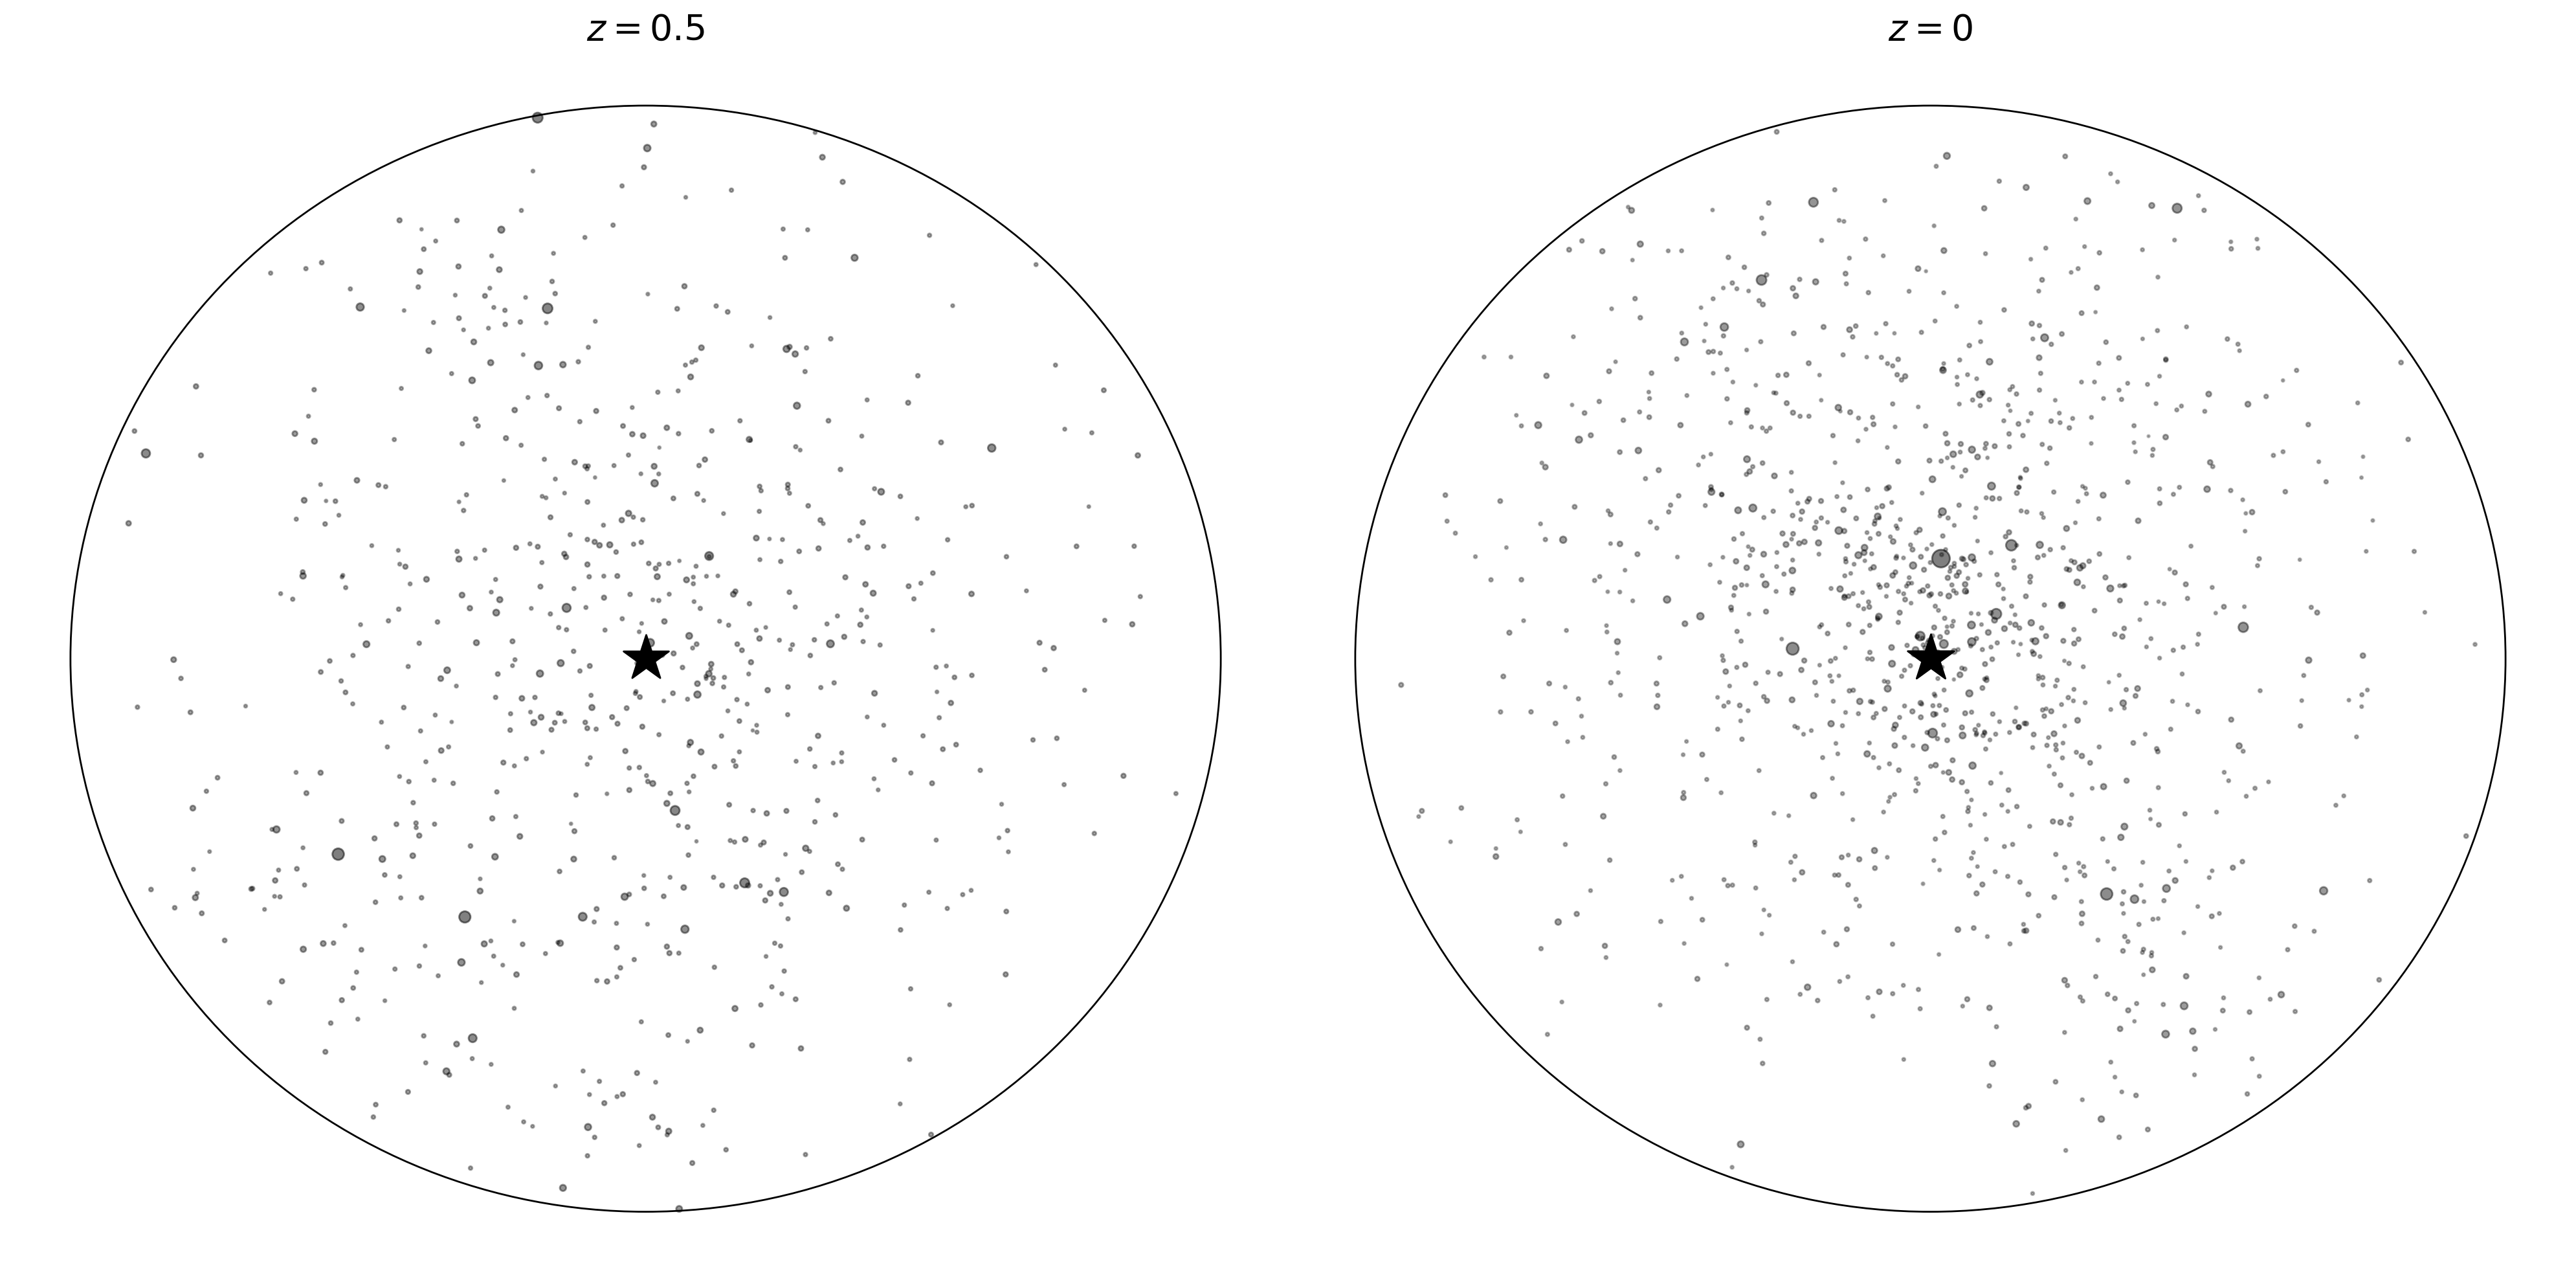

In [68]:
plt.figure(figsize=(20,10))

### z = 0.1
plt.subplot(121) 

plt.scatter(host_main_branch['x'][host_ind],host_main_branch['y'][host_ind],s=4*host_main_branch['rvir'][host_ind],
            marker='*',zorder=999,c=sim_colors['cdm'])
circle = plt.Circle((host_main_branch['x'][host_ind],host_main_branch['y'][host_ind]), host_main_branch['rvir'][host_ind]/1000.,
                   facecolor='none',edgecolor=sim_colors['cdm'])
plt.gca().add_patch(circle)

plt.scatter(subhalos_z_0_1['x'],subhalos_z_0_1['y'],s=subhalos_z_0_1['Rvir'],
            alpha=0.5*np.log10(subhalos_z_0_1['Mvir'])/np.max(np.log10(subhalos_z_0_1['Mvir'])),
            c=sim_colors['cdm'],zorder=998)

plt.axis('off')
plt.title(r'$z=0.5$',fontsize=20)
###

### z = 0
plt.subplot(122) 

plt.scatter(host_main_branch['x'][0],host_main_branch['y'][0],s=4*host_main_branch['rvir'][0],marker='*',zorder=999,
           c=sim_colors['cdm'])
circle = plt.Circle((host_main_branch['x'][0],host_main_branch['y'][0]), host_main_branch['rvir'][0]/1000.,
                   facecolor='none',edgecolor=sim_colors['cdm'])#, color='blue')
plt.gca().add_patch(circle)

plt.scatter(subhalos['x'],subhalos['y'],s=subhalos['Rvir'],
            alpha=0.5*np.log10(subhalos['Mvir'])/np.max(np.log10(subhalos['Mvir'])),c=sim_colors['cdm'],zorder=998)

plt.axis('off')
plt.title(r'$z=0$',fontsize=20)
###

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


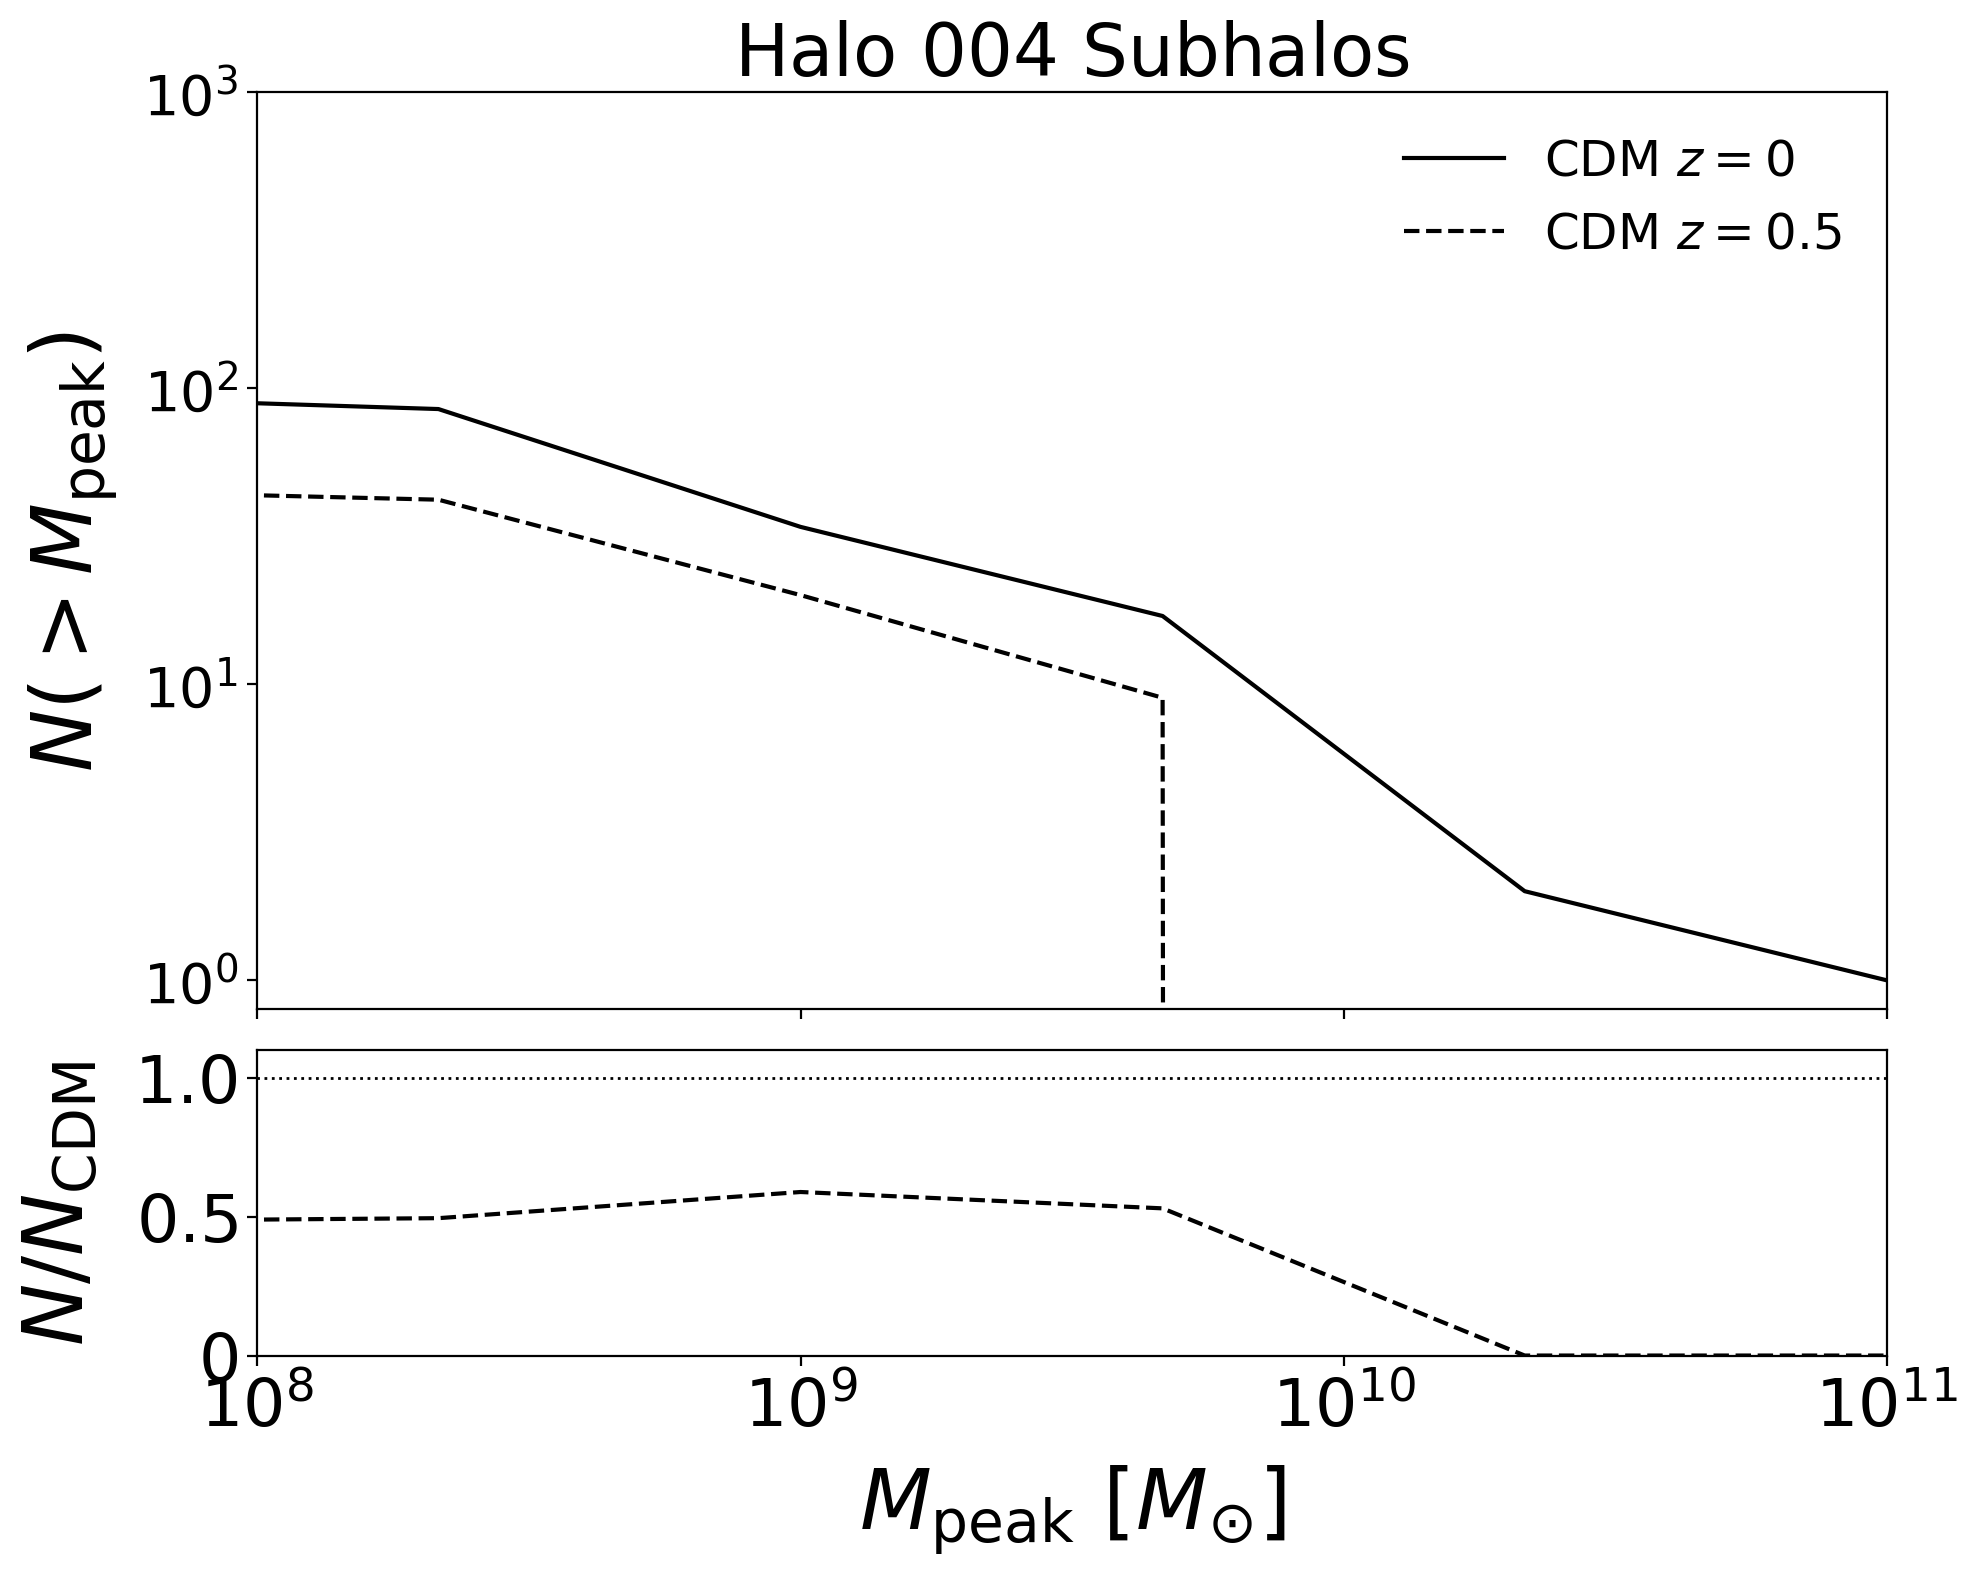

In [69]:
f, ax = plt.subplots(2,1, sharex='col', sharey='row', figsize=(10,8), gridspec_kw={'height_ratios':[3, 1]})
bins = np.linspace(5,11,10)

###

dist_ind_cdm = subhalos['Mvir']/0.7 > 1.2e8

CDM8K_values, CDM8K_base = np.histogram(np.log10(subhalos['Mpeak'][dist_ind_cdm]/0.7), bins=bins)
CDM8K_cumulative = np.cumsum(CDM8K_values)

ax[0].plot(CDM8K_base[1:], len(subhalos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative, 'k-',label='$\mathrm{CDM}\ z=0$')

###

dist_ind_cdm_z_0_1 = subhalos_z_0_1['Mvir']/0.7 > 1.2e8

CDM8K_values_z_0_1, CDM8K_base_z_0_1 = np.histogram(np.log10(subhalos_z_0_1['Mpeak'][dist_ind_cdm_z_0_1]/0.7), bins=bins)
CDM8K_cumulative_z_0_1 = np.cumsum(CDM8K_values_z_0_1)

ax[0].plot(CDM8K_base_z_0_1[1:], len(subhalos_z_0_1['Mpeak'][dist_ind_cdm_z_0_1])-CDM8K_cumulative_z_0_1,
           'k--',label='$\mathrm{CDM}\ z=0.5$')

###

#The bottom panel shows the ratio relative to CDM - which is just 1 when we only show CDM, but for other models

ax[1].plot(CDM8K_base[1:], CDM8K_base[:-1]-CDM8K_base[:-1]+1., 'k:', lw=1, zorder=999)
ax[1].plot(CDM8K_base[1:], (1.*len(subhalos_z_0_1['Mpeak'][dist_ind_cdm_z_0_1])-CDM8K_cumulative_z_0_1)/(1.*len(subhalos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative), 
               'k--')
###

ax[0].set_title(r'$\mathrm{Halo\ 004\ Subhalos}$',fontsize=26)
ax[0].set_yscale('log')
ax[0].set_yticks([1,10,100,1000])
ax[0].set_yticklabels([r'$10^0$',r'$10^1$',r'$10^2$',r'$10^3$'], fontsize=20)
ax[0].legend(loc=1, ncol=1, prop={'size':18}, frameon=False)
ax[0].set_ylabel(r'$N(>M_{\rm{peak}})$',fontsize=30,labelpad=8)
ax[0].minorticks_off()
ax[0].set_xlim(8,11)

ax[1].set_xticks([8,9,10,11])
ax[1].set_xticklabels([r'$10^8$',r'$10^9$',r'$10^{10}$',r'$10^{11}$'], fontsize=24)
ax[1].set_ylim(0,1.1)
ax[1].set_yticks([0,0.5,1.0])
ax[1].set_yticklabels([r'$0$',r'$0.5$',r'$1.0$'], fontsize=24)
ax[1].set_xlabel(r'$M_{\rm{peak}}\ [M_{\mathrm{\odot}}]$',fontsize=30,labelpad=8)
ax[1].set_ylabel(r'$N/N_{\rm{CDM}}$', fontsize=30, labelpad=12)
ax[1].tick_params(axis='x', which='minor', bottom=False)
ax[1].legend(loc=4,fontsize=16, frameon=False)
ax[1].minorticks_off()

###

plt.tight_layout()
plt.show()

## Exercises

### 1. Subhalo mass functions at other redshifts

Repeat the comparisons above for a few other redshifts. Qualitatively, how does the SHMF evolve over time? Why do you think this is?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


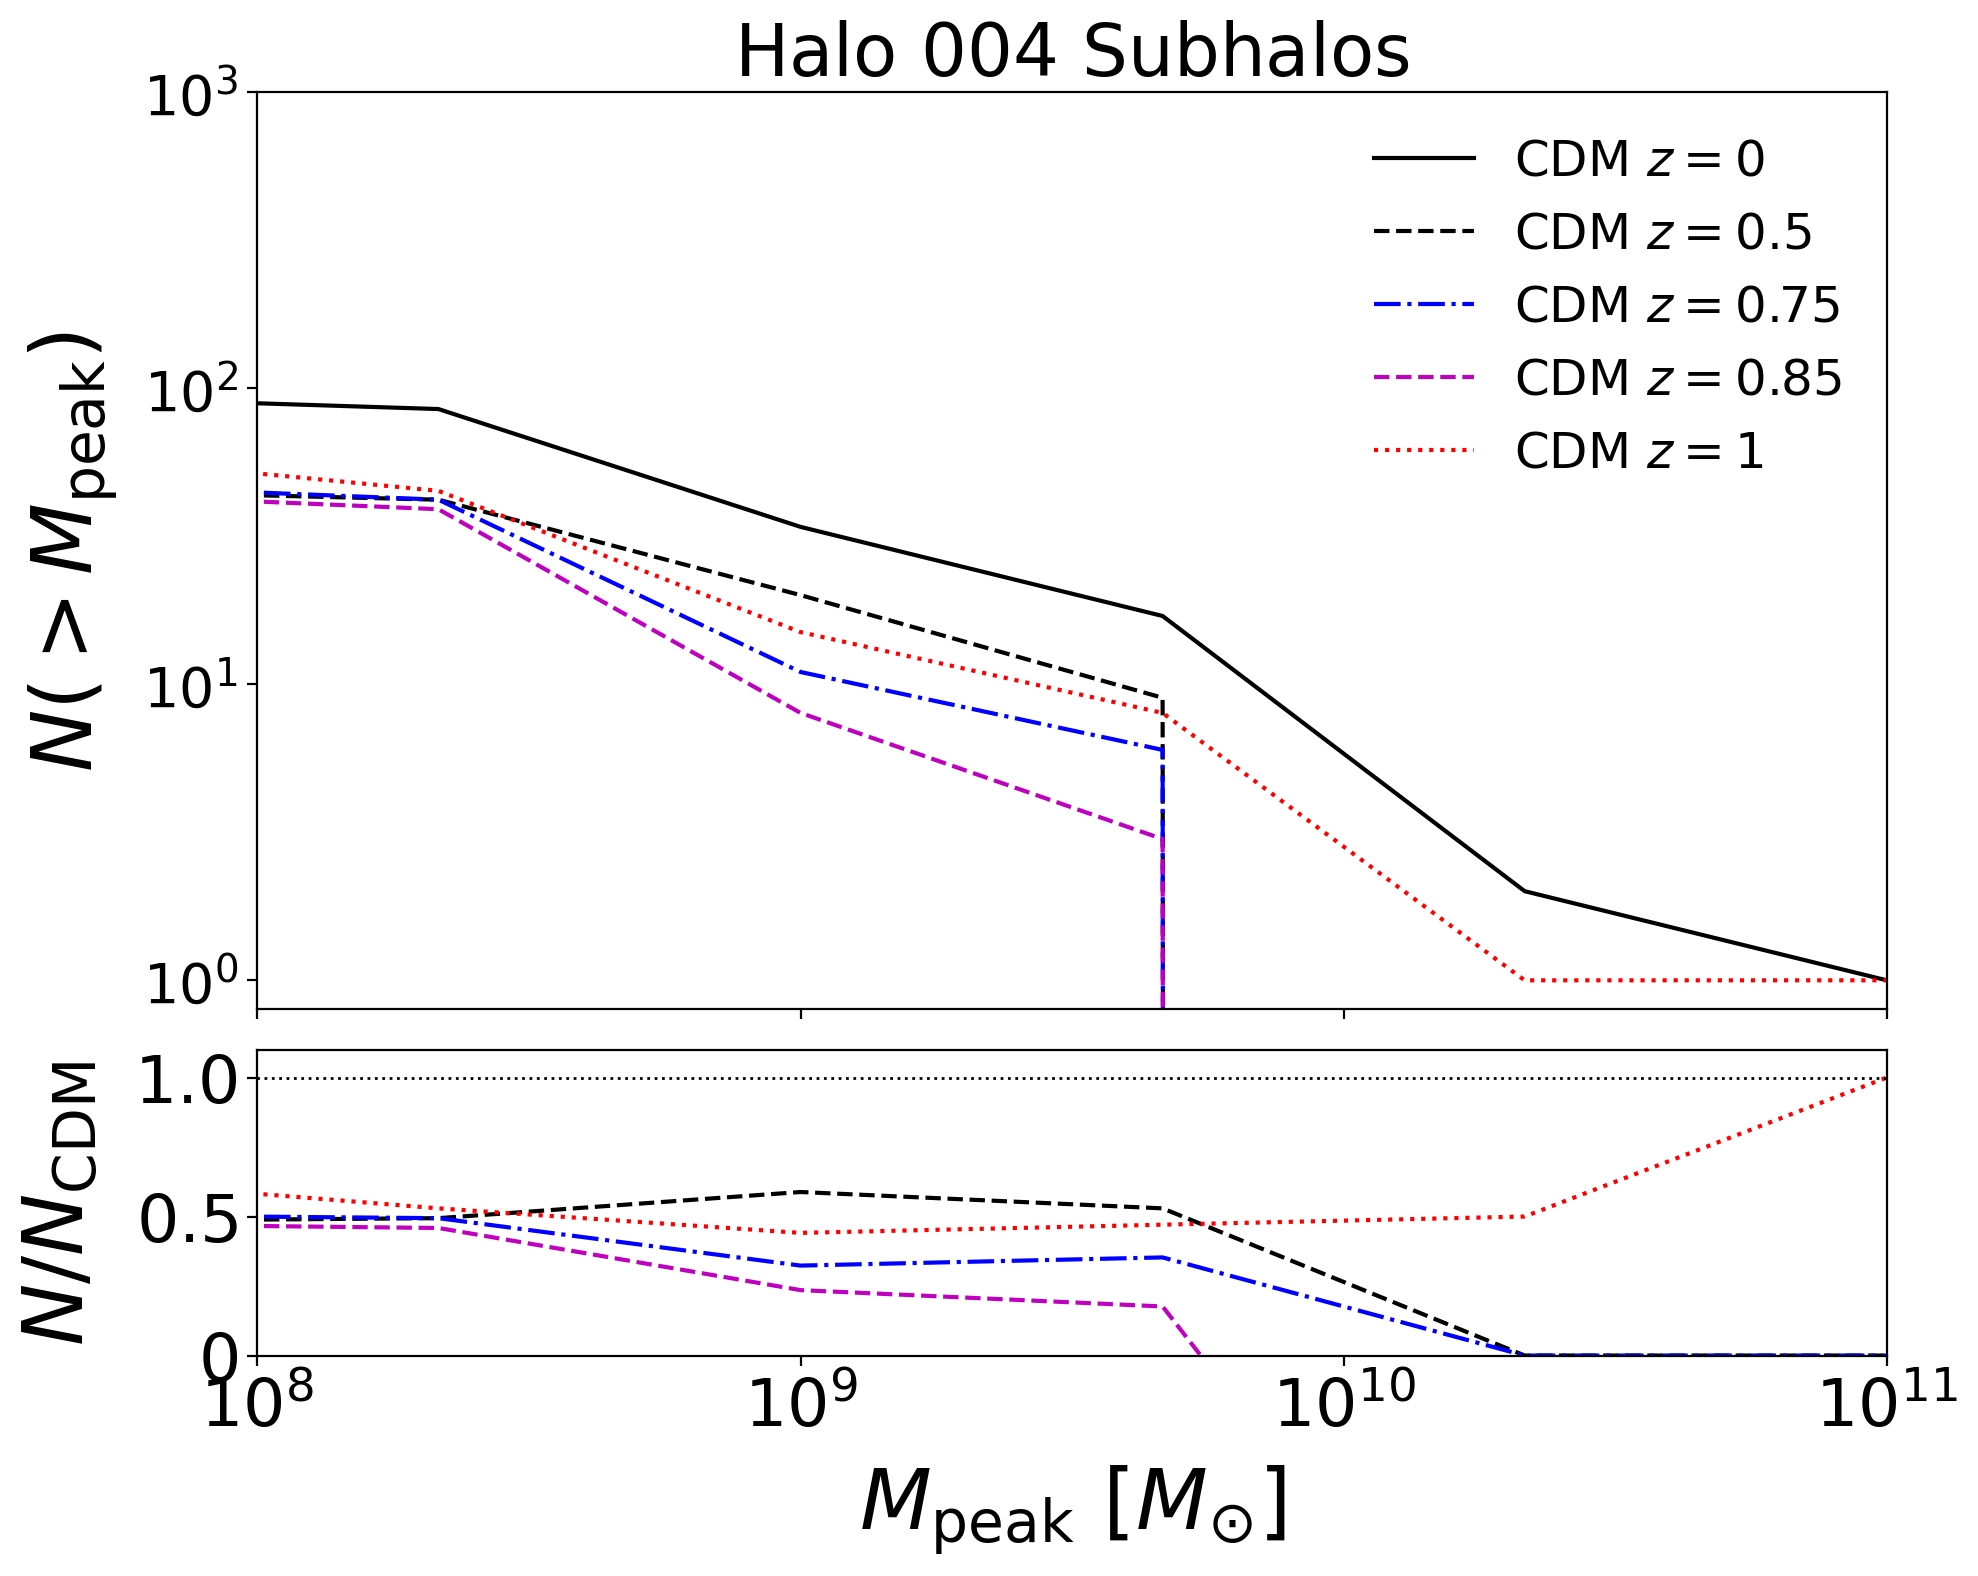

In [70]:
'''
TODO: start here after meeting with Vera/lunch
let's look at z = 0.75 and z = 1 (maybe add more redshifts later on).
'''

scale_75 = scale_factors[np.argmin(np.abs(scale_factors-(4.0/7.0)))] # closest to a = 4/7
scale_85 = scale_factors[np.argmin(np.abs(scale_factors-0.54))] # closest to a = 1/1.85
scale_1 = scale_factors[np.argmin(np.abs(scale_factors-0.5))] # closest to a = 0.58

halos_z_75, subhalos_z_75 = load_sim_data(scale_75, hlist_dictionary, sim_data[halo_num[:-1]][model[:-1]][0], 'cdm')
halos_z_85, subhalos_z_85 = load_sim_data(scale_85, hlist_dictionary, sim_data[halo_num[:-1]][model[:-1]][0], 'cdm')
halos_z_1, subhalos_z_1 = load_sim_data(scale_1, hlist_dictionary, sim_data[halo_num[:-1]][model[:-1]][0], 'cdm')

#......... plotting again!

f, ax = plt.subplots(2,1, sharex='col', sharey='row', figsize=(10,8), gridspec_kw={'height_ratios':[3, 1]})
bins = np.linspace(5,11,10)

###

dist_ind_cdm = subhalos['Mvir']/0.7 > 1.2e8

CDM8K_values, CDM8K_base = np.histogram(np.log10(subhalos['Mpeak'][dist_ind_cdm]/0.7), bins=bins)
CDM8K_cumulative = np.cumsum(CDM8K_values)

ax[0].plot(CDM8K_base[1:], len(subhalos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative, 'k-',label='$\mathrm{CDM}\ z=0$')

###

dist_ind_cdm_z_0_1 = subhalos_z_0_1['Mvir']/0.7 > 1.2e8

CDM8K_values_z_0_1, CDM8K_base_z_0_1 = np.histogram(np.log10(subhalos_z_0_1['Mpeak'][dist_ind_cdm_z_0_1]/0.7), bins=bins)
CDM8K_cumulative_z_0_1 = np.cumsum(CDM8K_values_z_0_1)

ax[0].plot(CDM8K_base_z_0_1[1:], len(subhalos_z_0_1['Mpeak'][dist_ind_cdm_z_0_1])-CDM8K_cumulative_z_0_1,
           'k--',label='$\mathrm{CDM}\ z=0.5$')


###

dist_ind_cdm_z_75 = subhalos_z_75['Mvir']/0.7 > 1.2e8

CDM8K_values_z_75, CDM8K_base_z_75 = np.histogram(np.log10(subhalos_z_75['Mpeak'][dist_ind_cdm_z_75]/0.7), bins=bins)
CDM8K_cumulative_z_75 = np.cumsum(CDM8K_values_z_75)

ax[0].plot(CDM8K_base_z_75[1:], len(subhalos_z_75['Mpeak'][dist_ind_cdm_z_75])-CDM8K_cumulative_z_75,
           'b-.',label='$\mathrm{CDM}\ z=0.75$')

###

dist_ind_cdm_z_85 = subhalos_z_85['Mvir']/0.7 > 1.2e8

CDM8K_values_z_85, CDM8K_base_z_85 = np.histogram(np.log10(subhalos_z_85['Mpeak'][dist_ind_cdm_z_85]/0.7), bins=bins)
CDM8K_cumulative_z_85 = np.cumsum(CDM8K_values_z_75)

ax[0].plot(CDM8K_base_z_85[1:], len(subhalos_z_85['Mpeak'][dist_ind_cdm_z_85])-CDM8K_cumulative_z_85,
           'm--',label='$\mathrm{CDM}\ z=0.85$')


###

dist_ind_cdm_z_1 = subhalos_z_1['Mvir']/0.7 > 1.2e8

CDM8K_values_z_1, CDM8K_base_z_1 = np.histogram(np.log10(subhalos_z_1['Mpeak'][dist_ind_cdm_z_1]/0.7), bins=bins)
CDM8K_cumulative_z_1 = np.cumsum(CDM8K_values_z_1)

ax[0].plot(CDM8K_base_z_1[1:], len(subhalos_z_1['Mpeak'][dist_ind_cdm_z_1])-CDM8K_cumulative_z_1,
           'r:',label='$\mathrm{CDM}\ z=1$')



###

#The bottom panel shows the ratio relative to CDM - which is just 1 when we only show CDM, but for other models

ax[1].plot(CDM8K_base[1:], CDM8K_base[:-1]-CDM8K_base[:-1]+1., 'k:', lw=1, zorder=999)
ax[1].plot(CDM8K_base[1:], (1.*len(subhalos_z_0_1['Mpeak'][dist_ind_cdm_z_0_1])-CDM8K_cumulative_z_0_1)/(1.*len(subhalos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative), 
               'k--')
ax[1].plot(CDM8K_base[1:], (1.*len(subhalos_z_75['Mpeak'][dist_ind_cdm_z_75])-CDM8K_cumulative_z_75)/(1.*len(subhalos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative), 
               'b-.')
ax[1].plot(CDM8K_base[1:], (1.*len(subhalos_z_85['Mpeak'][dist_ind_cdm_z_85])-CDM8K_cumulative_z_85)/(1.*len(subhalos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative), 
               'm--')
ax[1].plot(CDM8K_base[1:], (1.*len(subhalos_z_1['Mpeak'][dist_ind_cdm_z_1])-CDM8K_cumulative_z_1)/(1.*len(subhalos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative), 
               'r:')
###

ax[0].set_title(r'$\mathrm{Halo\ 004\ Subhalos}$',fontsize=26)
ax[0].set_yscale('log')
ax[0].set_yticks([1,10,100,1000])
ax[0].set_yticklabels([r'$10^0$',r'$10^1$',r'$10^2$',r'$10^3$'], fontsize=20)
ax[0].legend(loc=1, ncol=1, prop={'size':18}, frameon=False)
ax[0].set_ylabel(r'$N(>M_{\rm{peak}})$',fontsize=30,labelpad=8)
ax[0].minorticks_off()
ax[0].set_xlim(8,11)

ax[1].set_xticks([8,9,10,11])
ax[1].set_xticklabels([r'$10^8$',r'$10^9$',r'$10^{10}$',r'$10^{11}$'], fontsize=24)
ax[1].set_ylim(0,1.1)
ax[1].set_yticks([0,0.5,1.0])
ax[1].set_yticklabels([r'$0$',r'$0.5$',r'$1.0$'], fontsize=24)
ax[1].set_xlabel(r'$M_{\rm{peak}}\ [M_{\mathrm{\odot}}]$',fontsize=30,labelpad=8)
ax[1].set_ylabel(r'$N/N_{\rm{CDM}}$', fontsize=30, labelpad=12)
ax[1].tick_params(axis='x', which='minor', bottom=False)
ax[1].legend(loc=4,fontsize=16, frameon=False)
ax[1].minorticks_off()

###

plt.tight_layout()
plt.show()

### 2. Subhalo mass functions at other redshifts, in other models

Repeat the comparisons above in other models. Does the SHMF evolve differently in, e.g., CDM vs. WDM? We'll answer this question in much more detail over the summer; this is a first look at the results.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


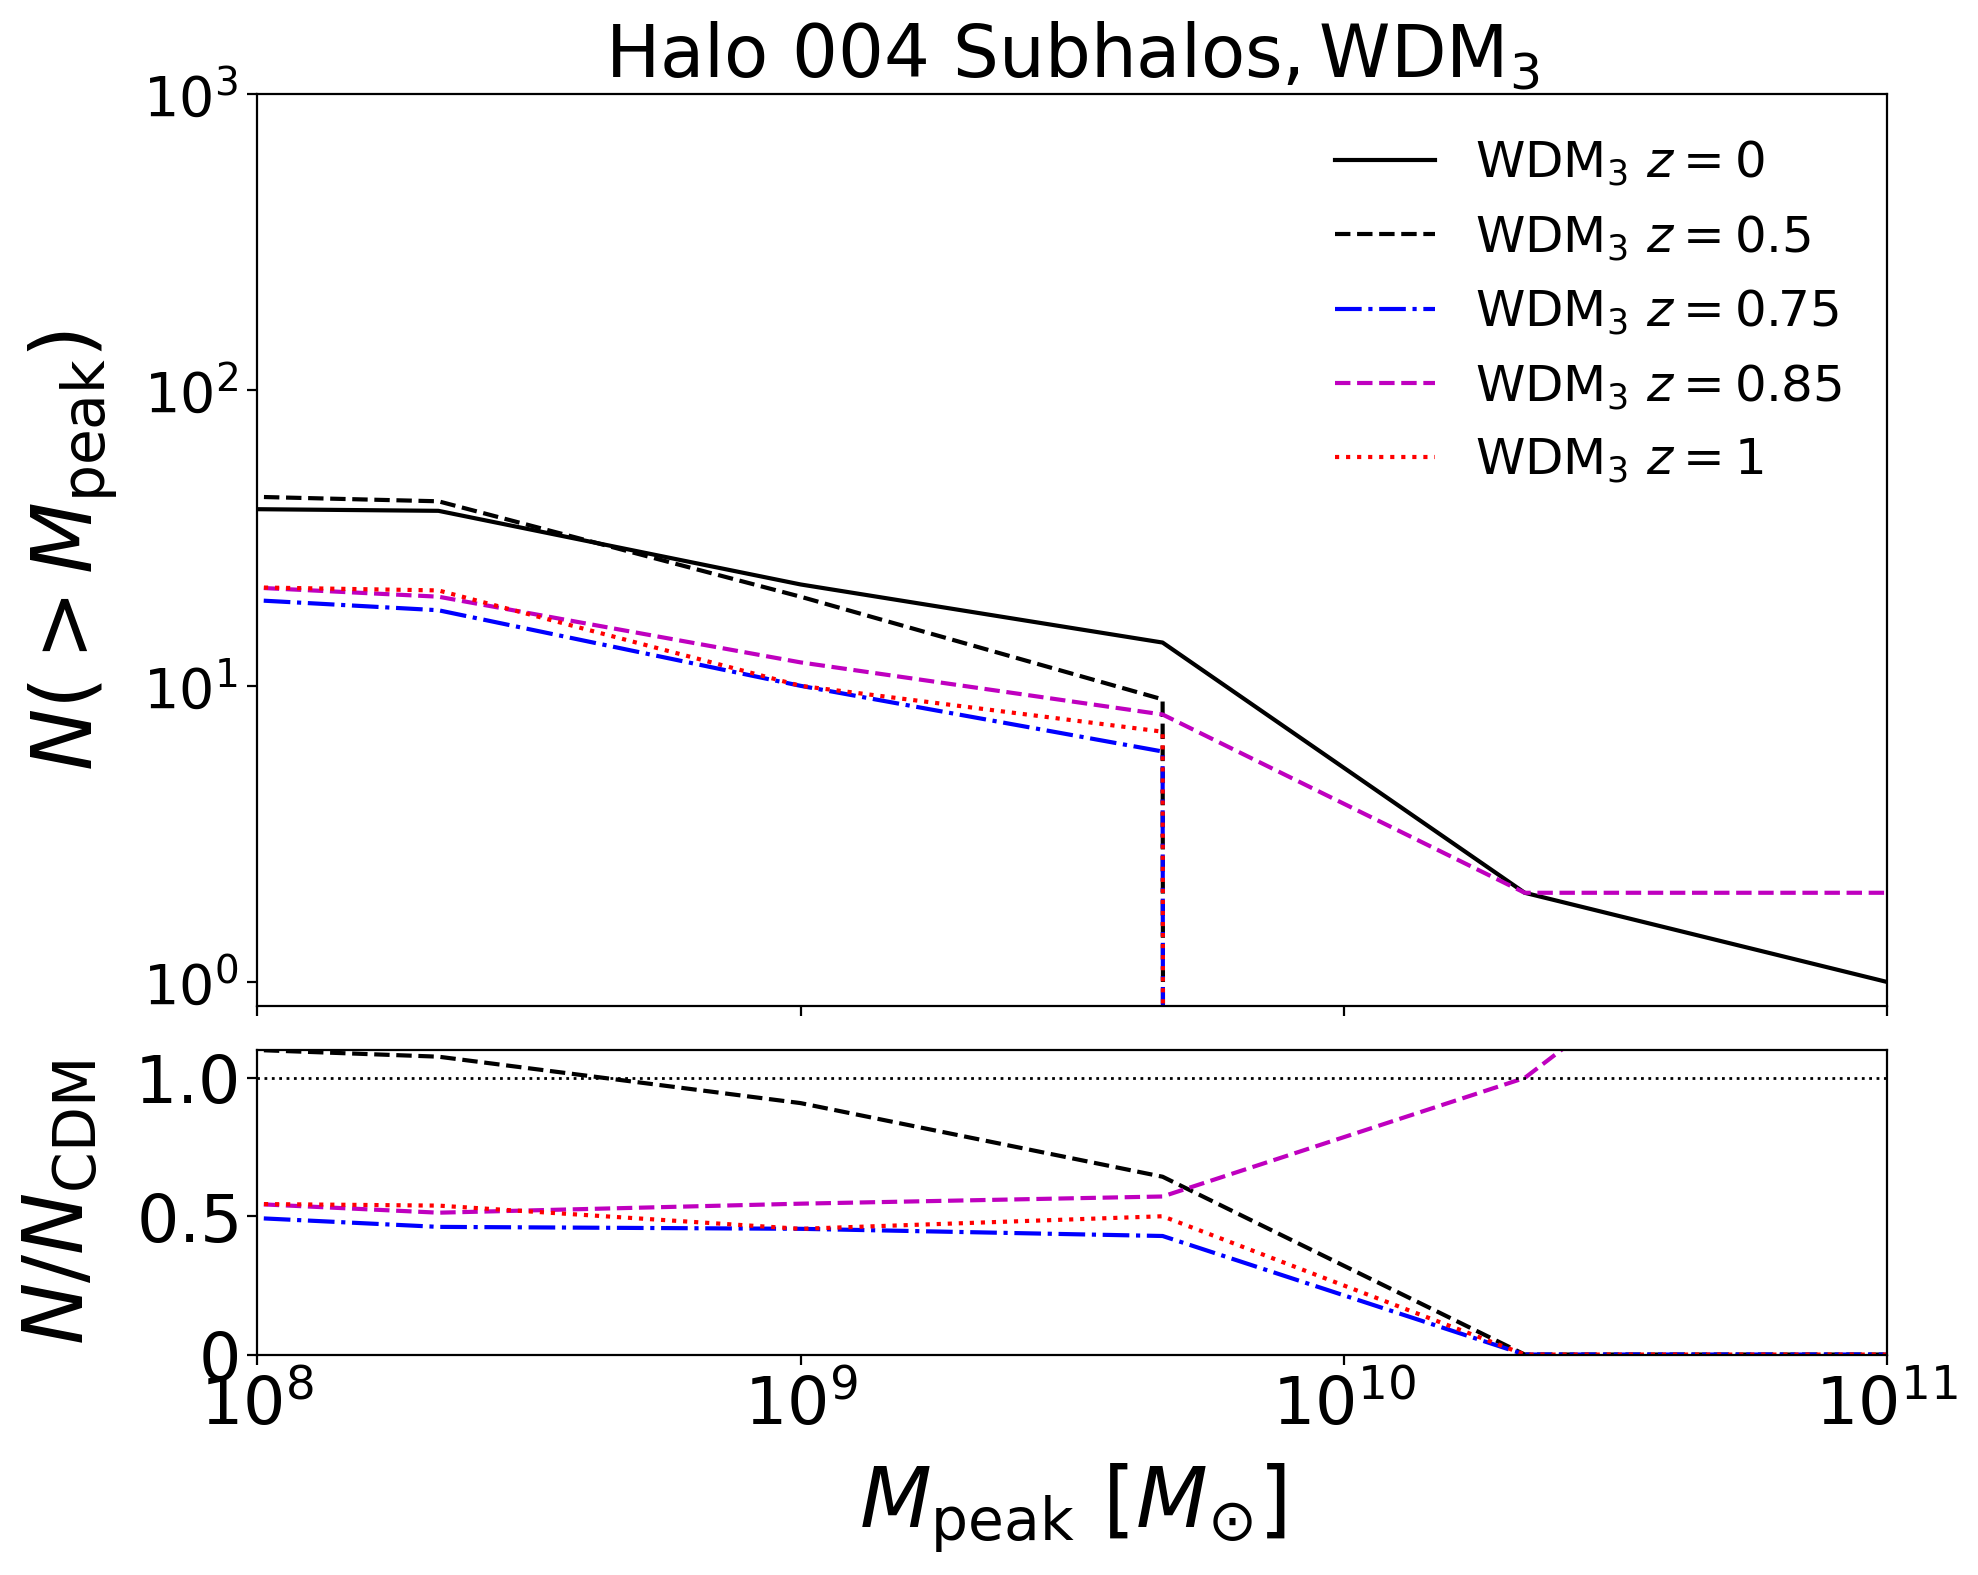

In [82]:
model='wdm_3/'

hlist_dictionary = {
    float(hlist[6:-5]): hlist
    for hlist in np.sort(os.listdir(BASE_PATH + f'hlists_{model}/'))
    # for hlist in np.sort(os.listdir(BASE_PATH + halo_num + model + 'output/rockstar/hlists/'))
}

scale_factors = np.array(list(hlist_dictionary.keys())) # list of scale factors

scale_75 = scale_factors[np.argmin(np.abs(scale_factors-(4.0/7.0)))] # closest to a = 4/7
scale_85 = scale_factors[np.argmin(np.abs(scale_factors-0.54))] # closest to a = 1/1.85
scale_1 = scale_factors[np.argmin(np.abs(scale_factors-0.5))] # closest to a = 0.58


halos, subhalos = load_sim_data(1.00000, hlist_dictionary, sim_data[halo_num[:-1]][model[:-1]][0], 'wdm_3')
halos_z_75, subhalos_z_75 = load_sim_data(scale_75, hlist_dictionary, sim_data[halo_num[:-1]][model[:-1]][0], 'wdm_3')
halos_z_85, subhalos_z_85 = load_sim_data(scale_85, hlist_dictionary, sim_data[halo_num[:-1]][model[:-1]][0], 'wdm_3')
halos_z_1, subhalos_z_1 = load_sim_data(scale_1, hlist_dictionary, sim_data[halo_num[:-1]][model[:-1]][0], 'wdm_3')

#......... plotting again!

f, ax = plt.subplots(2,1, sharex='col', sharey='row', figsize=(10,8), gridspec_kw={'height_ratios':[3, 1]})
bins = np.linspace(5,11,10)

###

dist_ind_cdm = subhalos['Mvir']/0.7 > 1.2e8

CDM8K_values, CDM8K_base = np.histogram(np.log10(subhalos['Mpeak'][dist_ind_cdm]/0.7), bins=bins)
CDM8K_cumulative = np.cumsum(CDM8K_values)

ax[0].plot(CDM8K_base[1:], len(subhalos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative, 'k-',label='$\mathrm{WDM_3}\ z=0$')

###

dist_ind_cdm_z_0_1 = subhalos_z_0_1['Mvir']/0.7 > 1.2e8

CDM8K_values_z_0_1, CDM8K_base_z_0_1 = np.histogram(np.log10(subhalos_z_0_1['Mpeak'][dist_ind_cdm_z_0_1]/0.7), bins=bins)
CDM8K_cumulative_z_0_1 = np.cumsum(CDM8K_values_z_0_1)

ax[0].plot(CDM8K_base_z_0_1[1:], len(subhalos_z_0_1['Mpeak'][dist_ind_cdm_z_0_1])-CDM8K_cumulative_z_0_1,
           'k--',label='$\mathrm{WDM_3}\ z=0.5$')


###

dist_ind_cdm_z_75 = subhalos_z_75['Mvir']/0.7 > 1.2e8

CDM8K_values_z_75, CDM8K_base_z_75 = np.histogram(np.log10(subhalos_z_75['Mpeak'][dist_ind_cdm_z_75]/0.7), bins=bins)
CDM8K_cumulative_z_75 = np.cumsum(CDM8K_values_z_75)

ax[0].plot(CDM8K_base_z_75[1:], len(subhalos_z_75['Mpeak'][dist_ind_cdm_z_75])-CDM8K_cumulative_z_75,
           'b-.',label='$\mathrm{WDM_3}\ z=0.75$')

###

dist_ind_cdm_z_85 = subhalos_z_85['Mvir']/0.7 > 1.2e8

CDM8K_values_z_85, CDM8K_base_z_85 = np.histogram(np.log10(subhalos_z_85['Mpeak'][dist_ind_cdm_z_85]/0.7), bins=bins)
CDM8K_cumulative_z_85 = np.cumsum(CDM8K_values_z_75)

ax[0].plot(CDM8K_base_z_85[1:], len(subhalos_z_85['Mpeak'][dist_ind_cdm_z_85])-CDM8K_cumulative_z_85,
           'm--',label='$\mathrm{WDM_3}\ z=0.85$')


###

dist_ind_cdm_z_1 = subhalos_z_1['Mvir']/0.7 > 1.2e8

CDM8K_values_z_1, CDM8K_base_z_1 = np.histogram(np.log10(subhalos_z_1['Mpeak'][dist_ind_cdm_z_1]/0.7), bins=bins)
CDM8K_cumulative_z_1 = np.cumsum(CDM8K_values_z_1)

ax[0].plot(CDM8K_base_z_1[1:], len(subhalos_z_1['Mpeak'][dist_ind_cdm_z_1])-CDM8K_cumulative_z_1,
           'r:',label='$\mathrm{WDM_3}\ z=1$')



###

#The bottom panel shows the ratio relative to CDM - which is just 1 when we only show CDM, but for other models

ax[1].plot(CDM8K_base[1:], CDM8K_base[:-1]-CDM8K_base[:-1]+1., 'k:', lw=1, zorder=999)
ax[1].plot(CDM8K_base[1:], (1.*len(subhalos_z_0_1['Mpeak'][dist_ind_cdm_z_0_1])-CDM8K_cumulative_z_0_1)/(1.*len(subhalos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative), 
               'k--')
ax[1].plot(CDM8K_base[1:], (1.*len(subhalos_z_75['Mpeak'][dist_ind_cdm_z_75])-CDM8K_cumulative_z_75)/(1.*len(subhalos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative), 
               'b-.')
ax[1].plot(CDM8K_base[1:], (1.*len(subhalos_z_85['Mpeak'][dist_ind_cdm_z_85])-CDM8K_cumulative_z_85)/(1.*len(subhalos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative), 
               'm--')
ax[1].plot(CDM8K_base[1:], (1.*len(subhalos_z_1['Mpeak'][dist_ind_cdm_z_1])-CDM8K_cumulative_z_1)/(1.*len(subhalos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative), 
               'r:')
###

ax[0].set_title(r'$\mathrm{Halo\ 004\ Subhalos, WDM_3}$',fontsize=26)
ax[0].set_yscale('log')
ax[0].set_yticks([1,10,100,1000])
ax[0].set_yticklabels([r'$10^0$',r'$10^1$',r'$10^2$',r'$10^3$'], fontsize=20)
ax[0].legend(loc=1, ncol=1, prop={'size':18}, frameon=False)
ax[0].set_ylabel(r'$N(>M_{\rm{peak}})$',fontsize=30,labelpad=8)
ax[0].minorticks_off()
ax[0].set_xlim(8,11)

ax[1].set_xticks([8,9,10,11])
ax[1].set_xticklabels([r'$10^8$',r'$10^9$',r'$10^{10}$',r'$10^{11}$'], fontsize=24)
ax[1].set_ylim(0,1.1)
ax[1].set_yticks([0,0.5,1.0])
ax[1].set_yticklabels([r'$0$',r'$0.5$',r'$1.0$'], fontsize=24)
ax[1].set_xlabel(r'$M_{\rm{peak}}\ [M_{\mathrm{\odot}}]$',fontsize=30,labelpad=8)
ax[1].set_ylabel(r'$N/N_{\rm{CDM}}$', fontsize=30, labelpad=12)
ax[1].tick_params(axis='x', which='minor', bottom=False)
ax[1].legend(loc=4,fontsize=16, frameon=False)
ax[1].minorticks_off()

###

plt.tight_layout()
plt.show()

### 3. Isolated halo mass function evolution

Repeat the HMF comparison at different redshifts for *isolated* halos. How does the isolated HMF evolution differ from the SHMF evolution?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


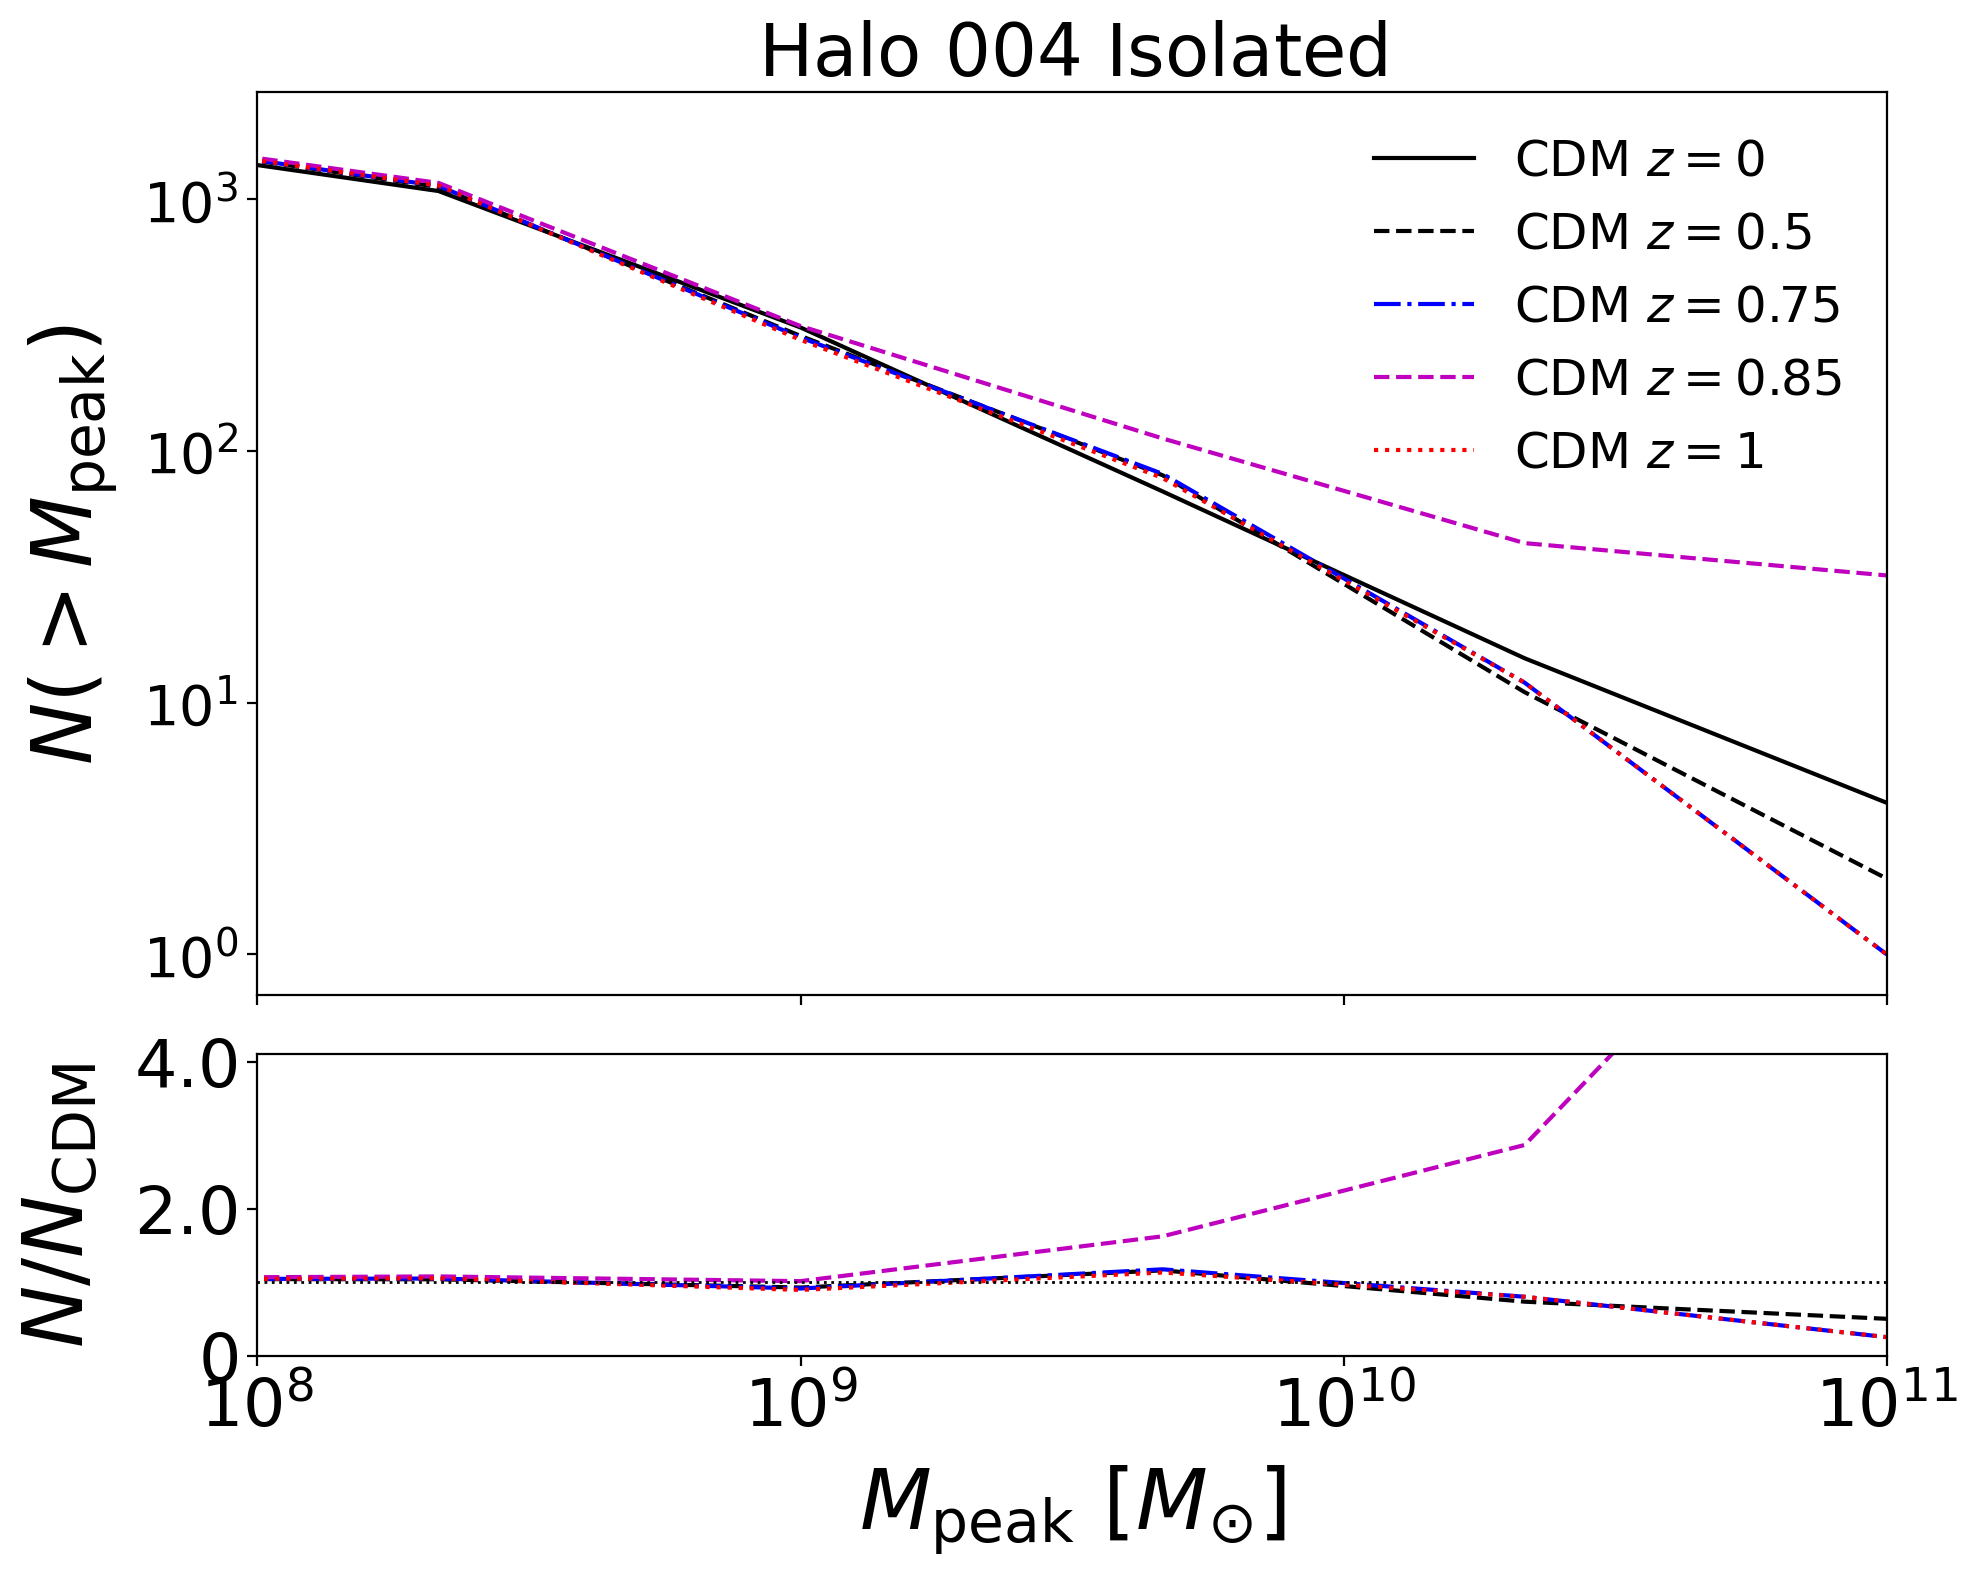

In [75]:
'''
TODO: start here after meeting with Vera/lunch
let's look at z = 0.75 and z = 1 (maybe add more redshifts later on).
'''

scale_75 = scale_factors[np.argmin(np.abs(scale_factors-(4.0/7.0)))] # closest to a = 4/7
scale_85 = scale_factors[np.argmin(np.abs(scale_factors-0.54))] # closest to a = 1/1.85
scale_1 = scale_factors[np.argmin(np.abs(scale_factors-0.5))] # closest to a = 0.58

halos_z_75, subhalos_z_75 = load_sim_data(scale_75, hlist_dictionary, sim_data[halo_num[:-1]][model[:-1]][0], 'cdm')
halos_z_85, subhalos_z_85 = load_sim_data(scale_85, hlist_dictionary, sim_data[halo_num[:-1]][model[:-1]][0], 'cdm')
halos_z_1, subhalos_z_1 = load_sim_data(scale_1, hlist_dictionary, sim_data[halo_num[:-1]][model[:-1]][0], 'cdm')

#......... plotting again!

f, ax = plt.subplots(2,1, sharex='col', sharey='row', figsize=(10,8), gridspec_kw={'height_ratios':[3, 1]})
bins = np.linspace(5,11,10)

###

dist_ind_cdm = halos['Mvir']/0.7 > 1.2e8

CDM8K_values, CDM8K_base = np.histogram(np.log10(halos['Mpeak'][dist_ind_cdm]/0.7), bins=bins)
CDM8K_cumulative = np.cumsum(CDM8K_values)

ax[0].plot(CDM8K_base[1:], len(halos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative, 'k-',label='$\mathrm{CDM}\ z=0$')

###

dist_ind_cdm_z_0_1 = halos_z_0_1['Mvir']/0.7 > 1.2e8

CDM8K_values_z_0_1, CDM8K_base_z_0_1 = np.histogram(np.log10(halos_z_0_1['Mpeak'][dist_ind_cdm_z_0_1]/0.7), bins=bins)
CDM8K_cumulative_z_0_1 = np.cumsum(CDM8K_values_z_0_1)

ax[0].plot(CDM8K_base_z_0_1[1:], len(halos_z_0_1['Mpeak'][dist_ind_cdm_z_0_1])-CDM8K_cumulative_z_0_1,
           'k--',label='$\mathrm{CDM}\ z=0.5$')


###

dist_ind_cdm_z_75 = halos_z_75['Mvir']/0.7 > 1.2e8

CDM8K_values_z_75, CDM8K_base_z_75 = np.histogram(np.log10(halos_z_75['Mpeak'][dist_ind_cdm_z_75]/0.7), bins=bins)
CDM8K_cumulative_z_75 = np.cumsum(CDM8K_values_z_75)

ax[0].plot(CDM8K_base_z_75[1:], len(halos_z_75['Mpeak'][dist_ind_cdm_z_75])-CDM8K_cumulative_z_75,
           'b-.',label='$\mathrm{CDM}\ z=0.75$')

###

dist_ind_cdm_z_85 = halos_z_85['Mvir']/0.7 > 1.2e8

CDM8K_values_z_85, CDM8K_base_z_85 = np.histogram(np.log10(halos_z_85['Mpeak'][dist_ind_cdm_z_85]/0.7), bins=bins)
CDM8K_cumulative_z_85 = np.cumsum(CDM8K_values_z_75)

ax[0].plot(CDM8K_base_z_85[1:], len(halos_z_85['Mpeak'][dist_ind_cdm_z_85])-CDM8K_cumulative_z_85,
           'm--',label='$\mathrm{CDM}\ z=0.85$')


###

dist_ind_cdm_z_1 = halos_z_1['Mvir']/0.7 > 1.2e8

CDM8K_values_z_1, CDM8K_base_z_1 = np.histogram(np.log10(halos_z_1['Mpeak'][dist_ind_cdm_z_1]/0.7), bins=bins)
CDM8K_cumulative_z_1 = np.cumsum(CDM8K_values_z_1)

ax[0].plot(CDM8K_base_z_1[1:], len(halos_z_1['Mpeak'][dist_ind_cdm_z_1])-CDM8K_cumulative_z_1,
           'r:',label='$\mathrm{CDM}\ z=1$')



###

#The bottom panel shows the ratio relative to CDM - which is just 1 when we only show CDM, but for other models

ax[1].plot(CDM8K_base[1:], CDM8K_base[:-1]-CDM8K_base[:-1]+1., 'k:', lw=1, zorder=999)
ax[1].plot(CDM8K_base[1:], (1.*len(halos_z_0_1['Mpeak'][dist_ind_cdm_z_0_1])-CDM8K_cumulative_z_0_1)/(1.*len(halos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative), 
               'k--')
ax[1].plot(CDM8K_base[1:], (1.*len(halos_z_75['Mpeak'][dist_ind_cdm_z_75])-CDM8K_cumulative_z_75)/(1.*len(halos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative), 
               'b-.')
ax[1].plot(CDM8K_base[1:], (1.*len(halos_z_85['Mpeak'][dist_ind_cdm_z_85])-CDM8K_cumulative_z_85)/(1.*len(halos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative), 
               'm--')
ax[1].plot(CDM8K_base[1:], (1.*len(halos_z_1['Mpeak'][dist_ind_cdm_z_1])-CDM8K_cumulative_z_1)/(1.*len(halos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative), 
               'r:')
###

ax[0].set_title(r'$\mathrm{Halo\ 004\ Isolated}$',fontsize=26)
ax[0].set_yscale('log')
ax[0].set_yticks([1,10,100,1000])
ax[0].set_yticklabels([r'$10^0$',r'$10^1$',r'$10^2$',r'$10^3$'], fontsize=20)
ax[0].legend(loc=1, ncol=1, prop={'size':18}, frameon=False)
ax[0].set_ylabel(r'$N(>M_{\rm{peak}})$',fontsize=30,labelpad=8)
ax[0].minorticks_off()
ax[0].set_xlim(8,11)

ax[1].set_xticks([8,9,10,11])
ax[1].set_xticklabels([r'$10^8$',r'$10^9$',r'$10^{10}$',r'$10^{11}$'], fontsize=24)
ax[1].set_ylim(0,4.1)
ax[1].set_yticks([0,2.0, 4.0])
ax[1].set_yticklabels([r'$0$',r'$2.0$', r'$4.0$'], fontsize=24)
ax[1].set_xlabel(r'$M_{\rm{peak}}\ [M_{\mathrm{\odot}}]$',fontsize=30,labelpad=8)
ax[1].set_ylabel(r'$N/N_{\rm{CDM}}$', fontsize=30, labelpad=12)
ax[1].tick_params(axis='x', which='minor', bottom=False)
ax[1].legend(loc=4,fontsize=16, frameon=False)
ax[1].minorticks_off()

###

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


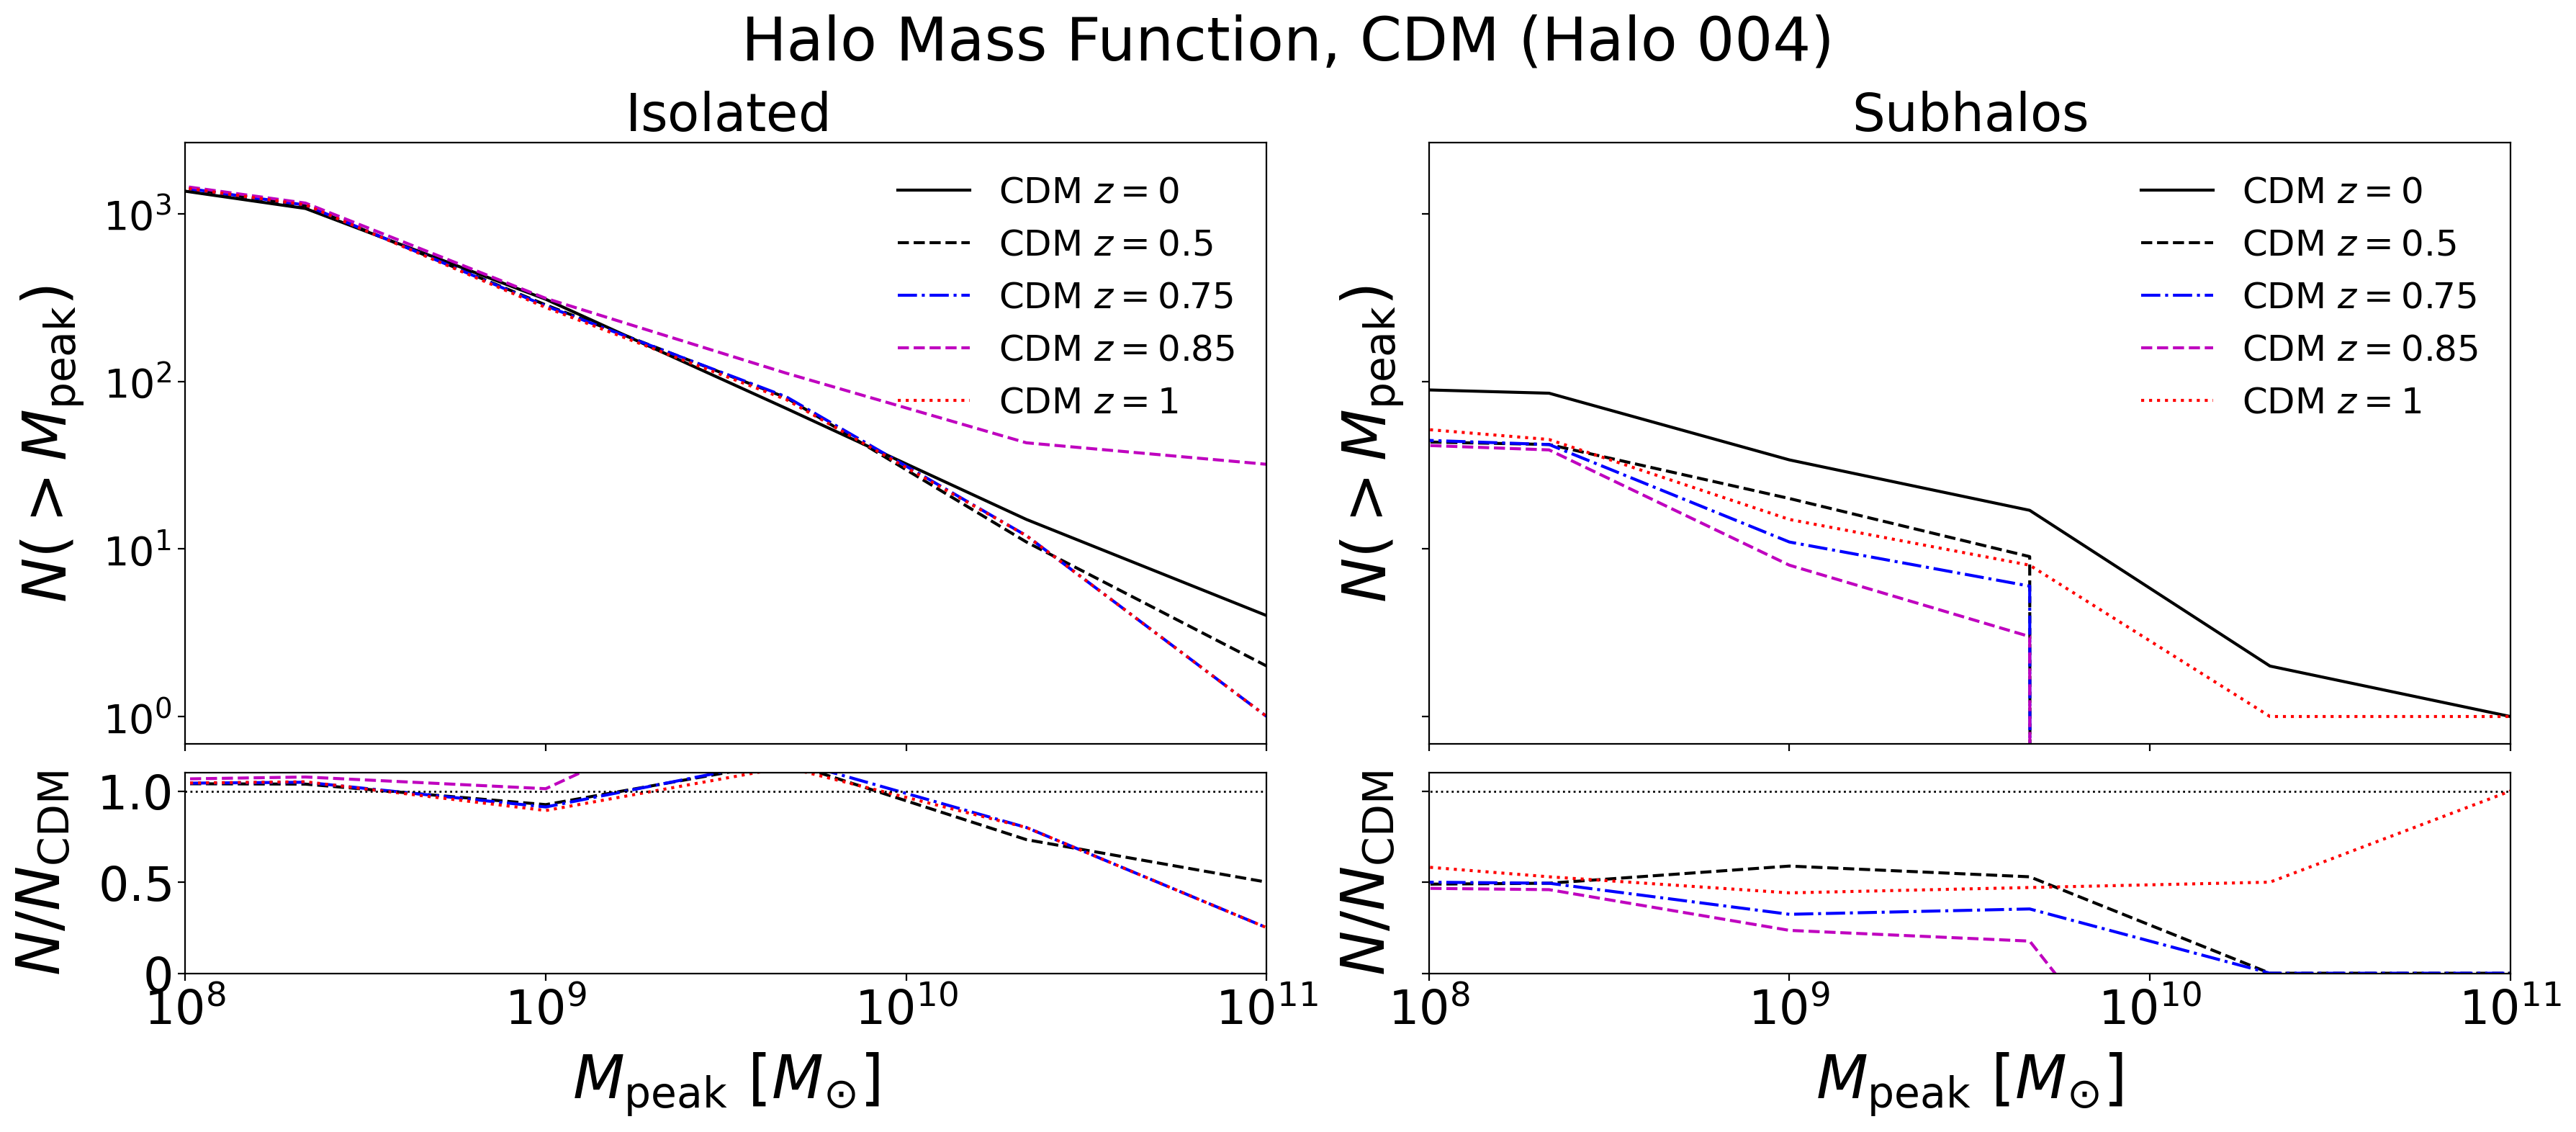

In [81]:
'''
TODO: start here after meeting with Vera/lunch
let's look at z = 0.75 and z = 1 (maybe add more redshifts later on).
'''

scale_75 = scale_factors[np.argmin(np.abs(scale_factors-(4.0/7.0)))] # closest to a = 4/7
scale_85 = scale_factors[np.argmin(np.abs(scale_factors-0.54))] # closest to a = 1/1.85
scale_1 = scale_factors[np.argmin(np.abs(scale_factors-0.5))] # closest to a = 0.58

halos_z_75, subhalos_z_75 = load_sim_data(scale_75, hlist_dictionary, sim_data[halo_num[:-1]][model[:-1]][0], 'cdm')
halos_z_85, subhalos_z_85 = load_sim_data(scale_85, hlist_dictionary, sim_data[halo_num[:-1]][model[:-1]][0], 'cdm')
halos_z_1, subhalos_z_1 = load_sim_data(scale_1, hlist_dictionary, sim_data[halo_num[:-1]][model[:-1]][0], 'cdm')

#......... plotting again!

f, ax = plt.subplots(2,2, sharex='col', sharey='row', figsize=(18,8), gridspec_kw={'height_ratios':[3, 1]})
bins = np.linspace(5,11,10)

###

dist_ind_cdm = halos['Mvir']/0.7 > 1.2e8

CDM8K_values, CDM8K_base = np.histogram(np.log10(halos['Mpeak'][dist_ind_cdm]/0.7), bins=bins)
CDM8K_cumulative = np.cumsum(CDM8K_values)

ax[0][0].plot(CDM8K_base[1:], len(halos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative, 'k-',label='$\mathrm{CDM}\ z=0$')

###

dist_ind_cdm_z_0_1 = halos_z_0_1['Mvir']/0.7 > 1.2e8

CDM8K_values_z_0_1, CDM8K_base_z_0_1 = np.histogram(np.log10(halos_z_0_1['Mpeak'][dist_ind_cdm_z_0_1]/0.7), bins=bins)
CDM8K_cumulative_z_0_1 = np.cumsum(CDM8K_values_z_0_1)

ax[0][0].plot(CDM8K_base_z_0_1[1:], len(halos_z_0_1['Mpeak'][dist_ind_cdm_z_0_1])-CDM8K_cumulative_z_0_1,
           'k--',label='$\mathrm{CDM}\ z=0.5$')


###

dist_ind_cdm_z_75 = halos_z_75['Mvir']/0.7 > 1.2e8

CDM8K_values_z_75, CDM8K_base_z_75 = np.histogram(np.log10(halos_z_75['Mpeak'][dist_ind_cdm_z_75]/0.7), bins=bins)
CDM8K_cumulative_z_75 = np.cumsum(CDM8K_values_z_75)

ax[0][0].plot(CDM8K_base_z_75[1:], len(halos_z_75['Mpeak'][dist_ind_cdm_z_75])-CDM8K_cumulative_z_75,
           'b-.',label='$\mathrm{CDM}\ z=0.75$')

###

dist_ind_cdm_z_85 = halos_z_85['Mvir']/0.7 > 1.2e8

CDM8K_values_z_85, CDM8K_base_z_85 = np.histogram(np.log10(halos_z_85['Mpeak'][dist_ind_cdm_z_85]/0.7), bins=bins)
CDM8K_cumulative_z_85 = np.cumsum(CDM8K_values_z_75)

ax[0][0].plot(CDM8K_base_z_85[1:], len(halos_z_85['Mpeak'][dist_ind_cdm_z_85])-CDM8K_cumulative_z_85,
           'm--',label='$\mathrm{CDM}\ z=0.85$')


###

dist_ind_cdm_z_1 = halos_z_1['Mvir']/0.7 > 1.2e8

CDM8K_values_z_1, CDM8K_base_z_1 = np.histogram(np.log10(halos_z_1['Mpeak'][dist_ind_cdm_z_1]/0.7), bins=bins)
CDM8K_cumulative_z_1 = np.cumsum(CDM8K_values_z_1)

ax[0][0].plot(CDM8K_base_z_1[1:], len(halos_z_1['Mpeak'][dist_ind_cdm_z_1])-CDM8K_cumulative_z_1,
           'r:',label='$\mathrm{CDM}\ z=1$')



###

#The bottom panel shows the ratio relative to CDM - which is just 1 when we only show CDM, but for other models

ax[1][0].plot(CDM8K_base[1:], CDM8K_base[:-1]-CDM8K_base[:-1]+1., 'k:', lw=1, zorder=999)
ax[1][0].plot(CDM8K_base[1:], (1.*len(halos_z_0_1['Mpeak'][dist_ind_cdm_z_0_1])-CDM8K_cumulative_z_0_1)/(1.*len(halos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative), 
               'k--')
ax[1][0].plot(CDM8K_base[1:], (1.*len(halos_z_75['Mpeak'][dist_ind_cdm_z_75])-CDM8K_cumulative_z_75)/(1.*len(halos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative), 
               'b-.')
ax[1][0].plot(CDM8K_base[1:], (1.*len(halos_z_85['Mpeak'][dist_ind_cdm_z_85])-CDM8K_cumulative_z_85)/(1.*len(halos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative), 
               'm--')
ax[1][0].plot(CDM8K_base[1:], (1.*len(halos_z_1['Mpeak'][dist_ind_cdm_z_1])-CDM8K_cumulative_z_1)/(1.*len(halos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative), 
               'r:')
###

ax[0][0].set_title(r'$\mathrm{Isolated}$',fontsize=26)
ax[0][0].set_yscale('log')
ax[0][0].set_yticks([1,10,100,1000])
ax[0][0].set_yticklabels([r'$10^0$',r'$10^1$',r'$10^2$',r'$10^3$'], fontsize=20)
ax[0][0].legend(loc=1, ncol=1, prop={'size':18}, frameon=False)
ax[0][0].set_ylabel(r'$N(>M_{\rm{peak}})$',fontsize=30,labelpad=8)
ax[0][0].minorticks_off()
ax[0][0].set_xlim(8,11)

ax[1][0].set_xticks([8,9,10,11])
ax[1][0].set_xticklabels([r'$10^8$',r'$10^9$',r'$10^{10}$',r'$10^{11}$'], fontsize=24)
ax[1][0].set_ylim(0,4.1)
ax[1][0].set_yticks([0,2.0, 4.0])
ax[1][0].set_yticklabels([r'$0$',r'$2.0$', r'$4.0$'], fontsize=24)
ax[1][0].set_xlabel(r'$M_{\rm{peak}}\ [M_{\mathrm{\odot}}]$',fontsize=30,labelpad=8)
ax[1][0].set_ylabel(r'$N/N_{\rm{CDM}}$', fontsize=30, labelpad=12)
ax[1][0].tick_params(axis='x', which='minor', bottom=False)
ax[1][0].legend(loc=4,fontsize=16, frameon=False)
ax[1][0].minorticks_off()

###

#....... subhalo mass function

###

dist_ind_cdm = subhalos['Mvir']/0.7 > 1.2e8

CDM8K_values, CDM8K_base = np.histogram(np.log10(subhalos['Mpeak'][dist_ind_cdm]/0.7), bins=bins)
CDM8K_cumulative = np.cumsum(CDM8K_values)

ax[0][1].plot(CDM8K_base[1:], len(subhalos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative, 'k-',label='$\mathrm{CDM}\ z=0$')

###

dist_ind_cdm_z_0_1 = subhalos_z_0_1['Mvir']/0.7 > 1.2e8

CDM8K_values_z_0_1, CDM8K_base_z_0_1 = np.histogram(np.log10(subhalos_z_0_1['Mpeak'][dist_ind_cdm_z_0_1]/0.7), bins=bins)
CDM8K_cumulative_z_0_1 = np.cumsum(CDM8K_values_z_0_1)

ax[0][1].plot(CDM8K_base_z_0_1[1:], len(subhalos_z_0_1['Mpeak'][dist_ind_cdm_z_0_1])-CDM8K_cumulative_z_0_1,
           'k--',label='$\mathrm{CDM}\ z=0.5$')


###

dist_ind_cdm_z_75 = subhalos_z_75['Mvir']/0.7 > 1.2e8

CDM8K_values_z_75, CDM8K_base_z_75 = np.histogram(np.log10(subhalos_z_75['Mpeak'][dist_ind_cdm_z_75]/0.7), bins=bins)
CDM8K_cumulative_z_75 = np.cumsum(CDM8K_values_z_75)

ax[0][1].plot(CDM8K_base_z_75[1:], len(subhalos_z_75['Mpeak'][dist_ind_cdm_z_75])-CDM8K_cumulative_z_75,
           'b-.',label='$\mathrm{CDM}\ z=0.75$')

###

dist_ind_cdm_z_85 = subhalos_z_85['Mvir']/0.7 > 1.2e8

CDM8K_values_z_85, CDM8K_base_z_85 = np.histogram(np.log10(subhalos_z_85['Mpeak'][dist_ind_cdm_z_85]/0.7), bins=bins)
CDM8K_cumulative_z_85 = np.cumsum(CDM8K_values_z_75)

ax[0][1].plot(CDM8K_base_z_85[1:], len(subhalos_z_85['Mpeak'][dist_ind_cdm_z_85])-CDM8K_cumulative_z_85,
           'm--',label='$\mathrm{CDM}\ z=0.85$')


###

dist_ind_cdm_z_1 = subhalos_z_1['Mvir']/0.7 > 1.2e8

CDM8K_values_z_1, CDM8K_base_z_1 = np.histogram(np.log10(subhalos_z_1['Mpeak'][dist_ind_cdm_z_1]/0.7), bins=bins)
CDM8K_cumulative_z_1 = np.cumsum(CDM8K_values_z_1)

ax[0][1].plot(CDM8K_base_z_1[1:], len(subhalos_z_1['Mpeak'][dist_ind_cdm_z_1])-CDM8K_cumulative_z_1,
           'r:',label='$\mathrm{CDM}\ z=1$')



###

#The bottom panel shows the ratio relative to CDM - which is just 1 when we only show CDM, but for other models

ax[1][1].plot(CDM8K_base[1:], CDM8K_base[:-1]-CDM8K_base[:-1]+1., 'k:', lw=1, zorder=999)
ax[1][1].plot(CDM8K_base[1:], (1.*len(subhalos_z_0_1['Mpeak'][dist_ind_cdm_z_0_1])-CDM8K_cumulative_z_0_1)/(1.*len(subhalos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative), 
               'k--')
ax[1][1].plot(CDM8K_base[1:], (1.*len(subhalos_z_75['Mpeak'][dist_ind_cdm_z_75])-CDM8K_cumulative_z_75)/(1.*len(subhalos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative), 
               'b-.')
ax[1][1].plot(CDM8K_base[1:], (1.*len(subhalos_z_85['Mpeak'][dist_ind_cdm_z_85])-CDM8K_cumulative_z_85)/(1.*len(subhalos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative), 
               'm--')
ax[1][1].plot(CDM8K_base[1:], (1.*len(subhalos_z_1['Mpeak'][dist_ind_cdm_z_1])-CDM8K_cumulative_z_1)/(1.*len(subhalos['Mpeak'][dist_ind_cdm])-CDM8K_cumulative), 
               'r:')
###

ax[0][1].set_title(r'$\mathrm{Subhalos}$',fontsize=26)
ax[0][1].set_yscale('log')
ax[0][1].set_yticks([1,10,100,1000])
ax[0][1].set_yticklabels([r'$10^0$',r'$10^1$',r'$10^2$',r'$10^3$'], fontsize=20)
ax[0][1].legend(loc=1, ncol=1, prop={'size':18}, frameon=False)
ax[0][1].set_ylabel(r'$N(>M_{\rm{peak}})$',fontsize=30,labelpad=8)
ax[0][1].minorticks_off()
ax[0][1].set_xlim(8,11)

ax[1][1].set_xticks([8,9,10,11])
ax[1][1].set_xticklabels([r'$10^8$',r'$10^9$',r'$10^{10}$',r'$10^{11}$'], fontsize=24)
ax[1][1].set_ylim(0,1.1)
ax[1][1].set_yticks([0,0.5,1.0])
ax[1][1].set_yticklabels([r'$0$',r'$0.5$',r'$1.0$'], fontsize=24)
ax[1][1].set_xlabel(r'$M_{\rm{peak}}\ [M_{\mathrm{\odot}}]$',fontsize=30,labelpad=8)
ax[1][1].set_ylabel(r'$N/N_{\rm{CDM}}$', fontsize=30, labelpad=12)
ax[1][1].tick_params(axis='x', which='minor', bottom=False)
ax[1][1].legend(loc=4,fontsize=16, frameon=False)
ax[1][1].minorticks_off()

###

plt.suptitle('Halo Mass Function, CDM (Halo 004)', fontsize=30)
plt.tight_layout()
plt.show()